# Mr.ASH penalized regression trendfiltering demo

- toc: true
- badges: true
- comments: true
- categories: [trend-filtering, dsc, mr-ash, regression-methods]
- slug: mrash-penalized-trend-filtering-demo

### About

Demonstration of Mr.ASH penalized regression on trendfiltering problems and optimization of $w_k$

In [1]:
#collapse-hide

import numpy as np
from mrashpen.inference.penalized_regression import PenalizedRegression as MrASHPen
from mrashpen.models.normal_means_ash import NormalMeansASH

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

Simulate trendfiltering data with basis k = 0

In [2]:
#collapse-hide

n = 100
p = 100
p_causal = 4
snr = 20
k = 5

X, y, Xtest, ytest, beta, se = simulate.changepoint_predictors (n, p, p_causal, snr, 
                                                                k = 0, signal = 'gamma', seed = 20)

residual_var = se * se

### Fit data with Mr.Ash.Pen

First, I use fixed priors $w_k$ and fixed residual variance.

Initial w:  [0.   0.25 0.25 0.25 0.25]
Prior_grid:  [ 0 10 20 30 40]



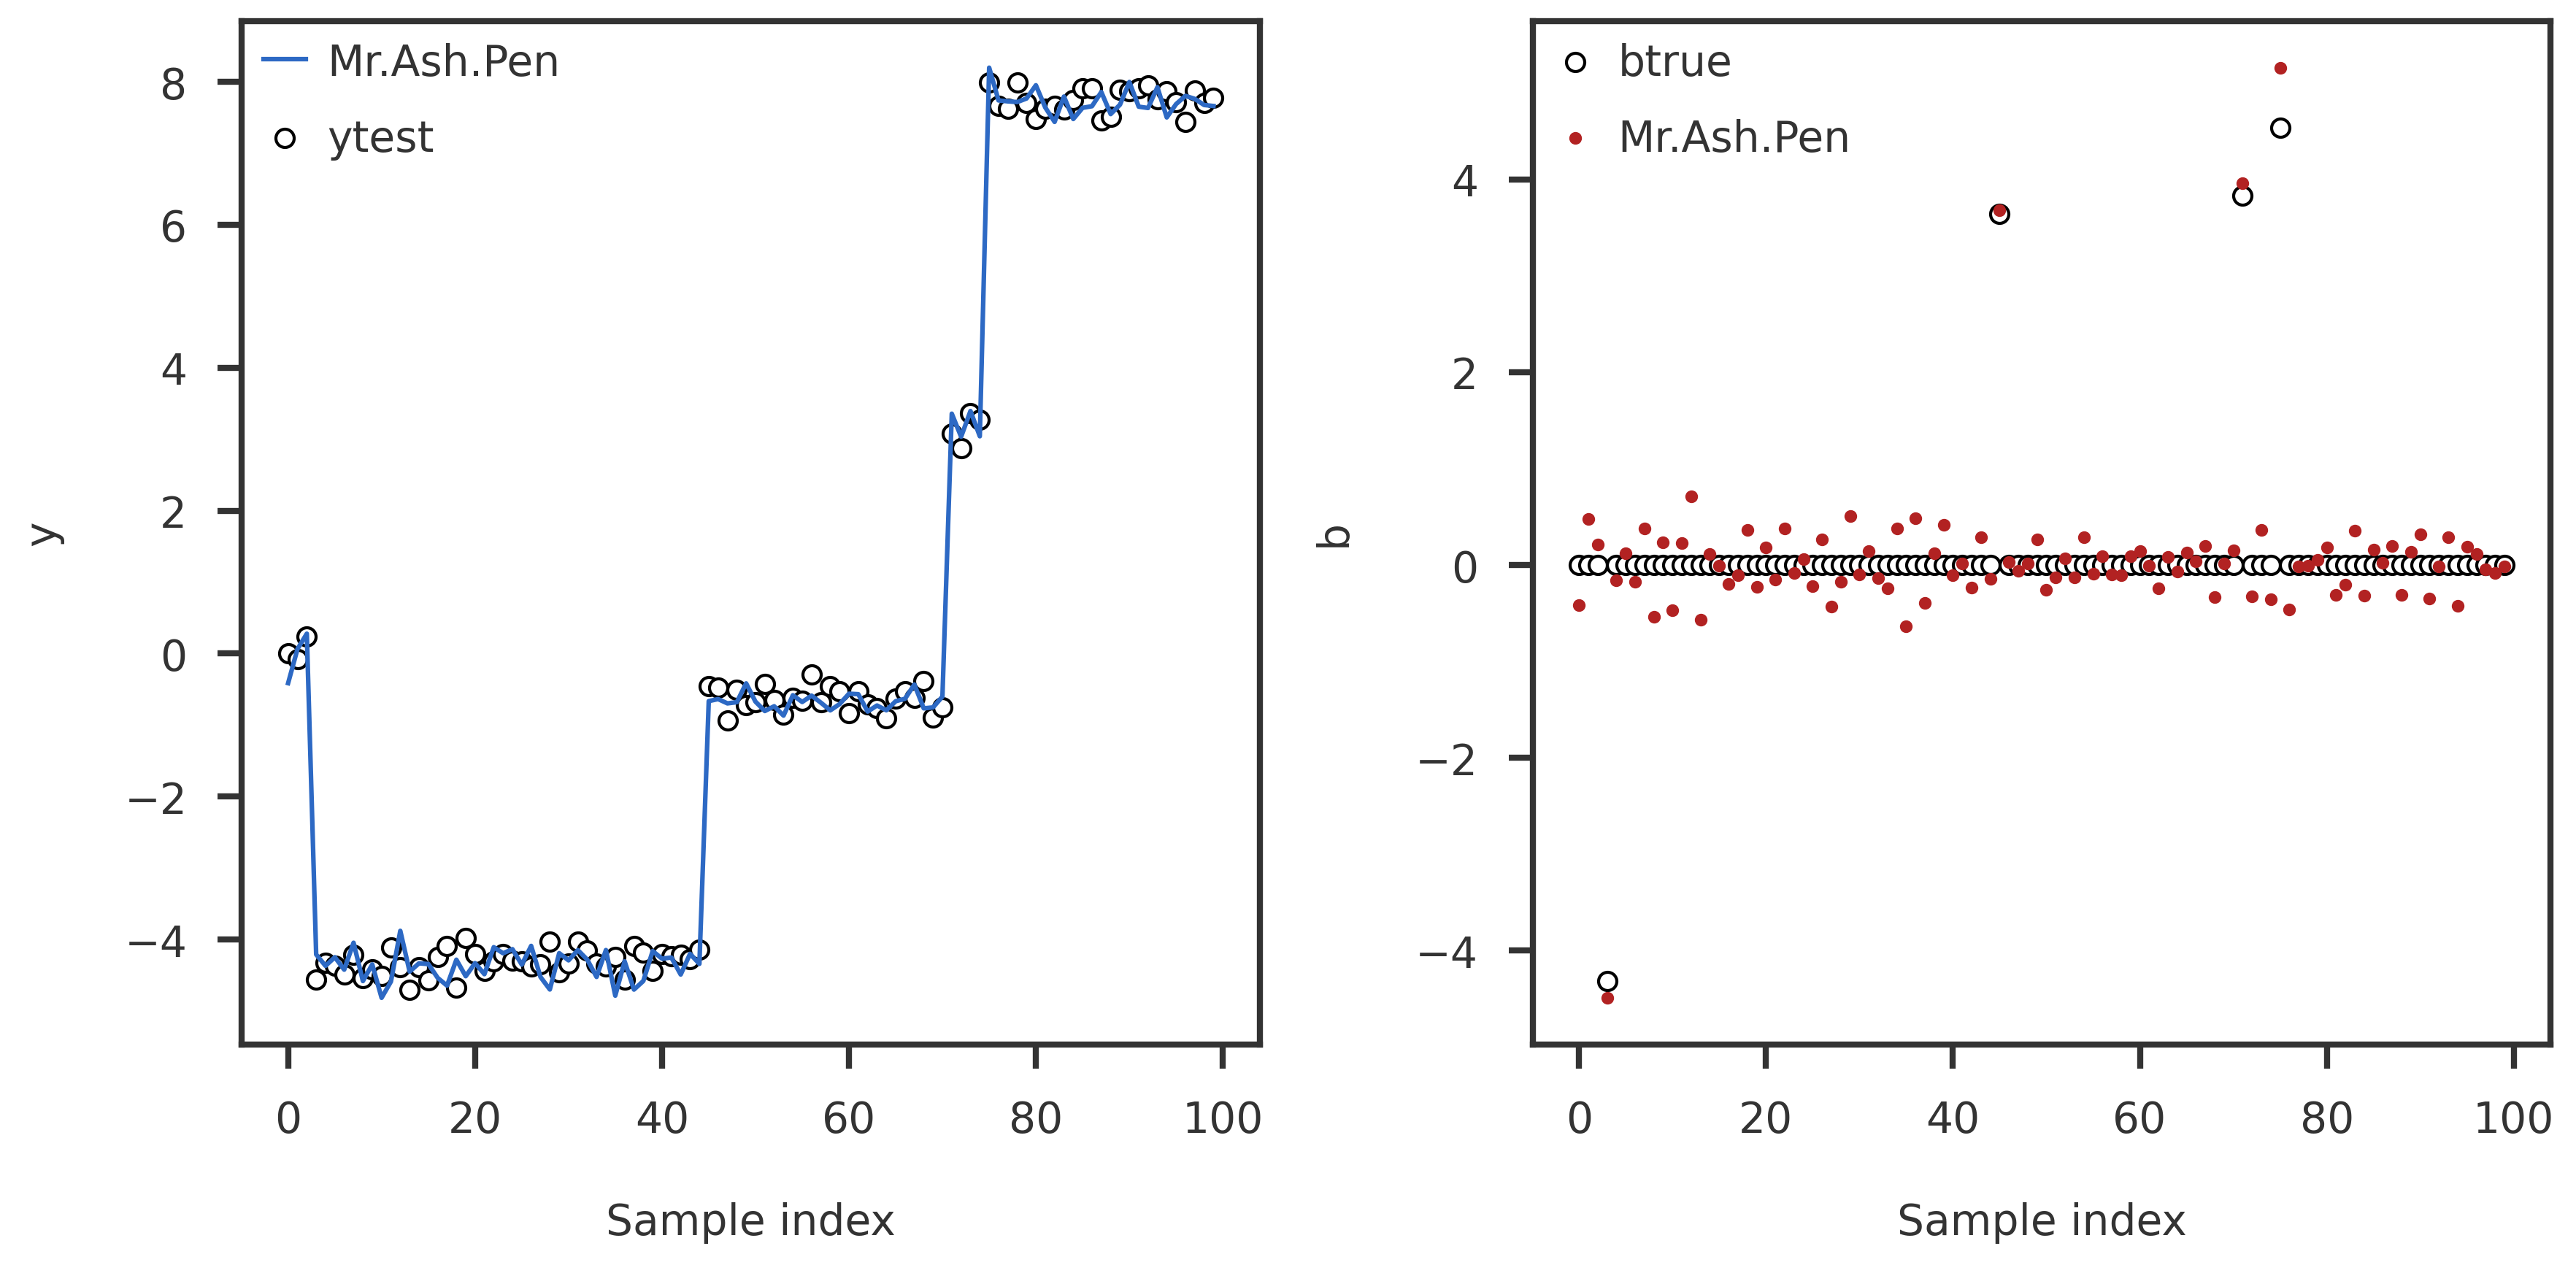

In [3]:
#collapse-hide

def plot_trendfilter_mrashpen(X, y, beta, ytest, res):
    n = y.shape[0]
    p = X.shape[1]

    bhat = res.coef

    ypred = np.dot(X, bhat)
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(np.arange(n), ytest, edgecolor = 'black', facecolor='white', label="ytest")
    ax1.plot(np.arange(n), ypred, label="Mr.Ash.Pen")
    ax1.legend()
    ax1.set_xlabel("Sample index")
    ax1.set_ylabel("y")

    ax2.scatter(np.arange(p), beta, edgecolor = 'black', facecolor = 'white', label = "btrue")
    ax2.scatter(np.arange(p), bhat, s = 10, color = 'firebrick', label = "Mr.Ash.Pen")
    ax2.legend()
    ax2.set_xlabel("Sample index")
    ax2.set_ylabel("b")

    plt.tight_layout()
    plt.show()

## Prior
w = np.zeros(k)
w[0] = 0
w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
w[k-1] = 1 - np.sum(w)
prior_grid = np.arange(k) * 10

print("Initial w: ", w)
print("Prior_grid: ", prior_grid)
print()

b0 = np.zeros(p)
plr_lbfgs = MrASHPen(optimize_w = False, debug = False)
plr_lbfgs.fit(X, y, prior_grid, binit = b0, winit = w, s2init = residual_var)

plot_trendfilter_mrashpen(X, y, beta, ytest, plr_lbfgs)

Then, we try to optimize $w_k$ using the penalty function $h(b, w)$.

Using w:  [0.   0.25 0.25 0.25 0.25]
Using prior_grid:  [ 1 11 21 31 41]



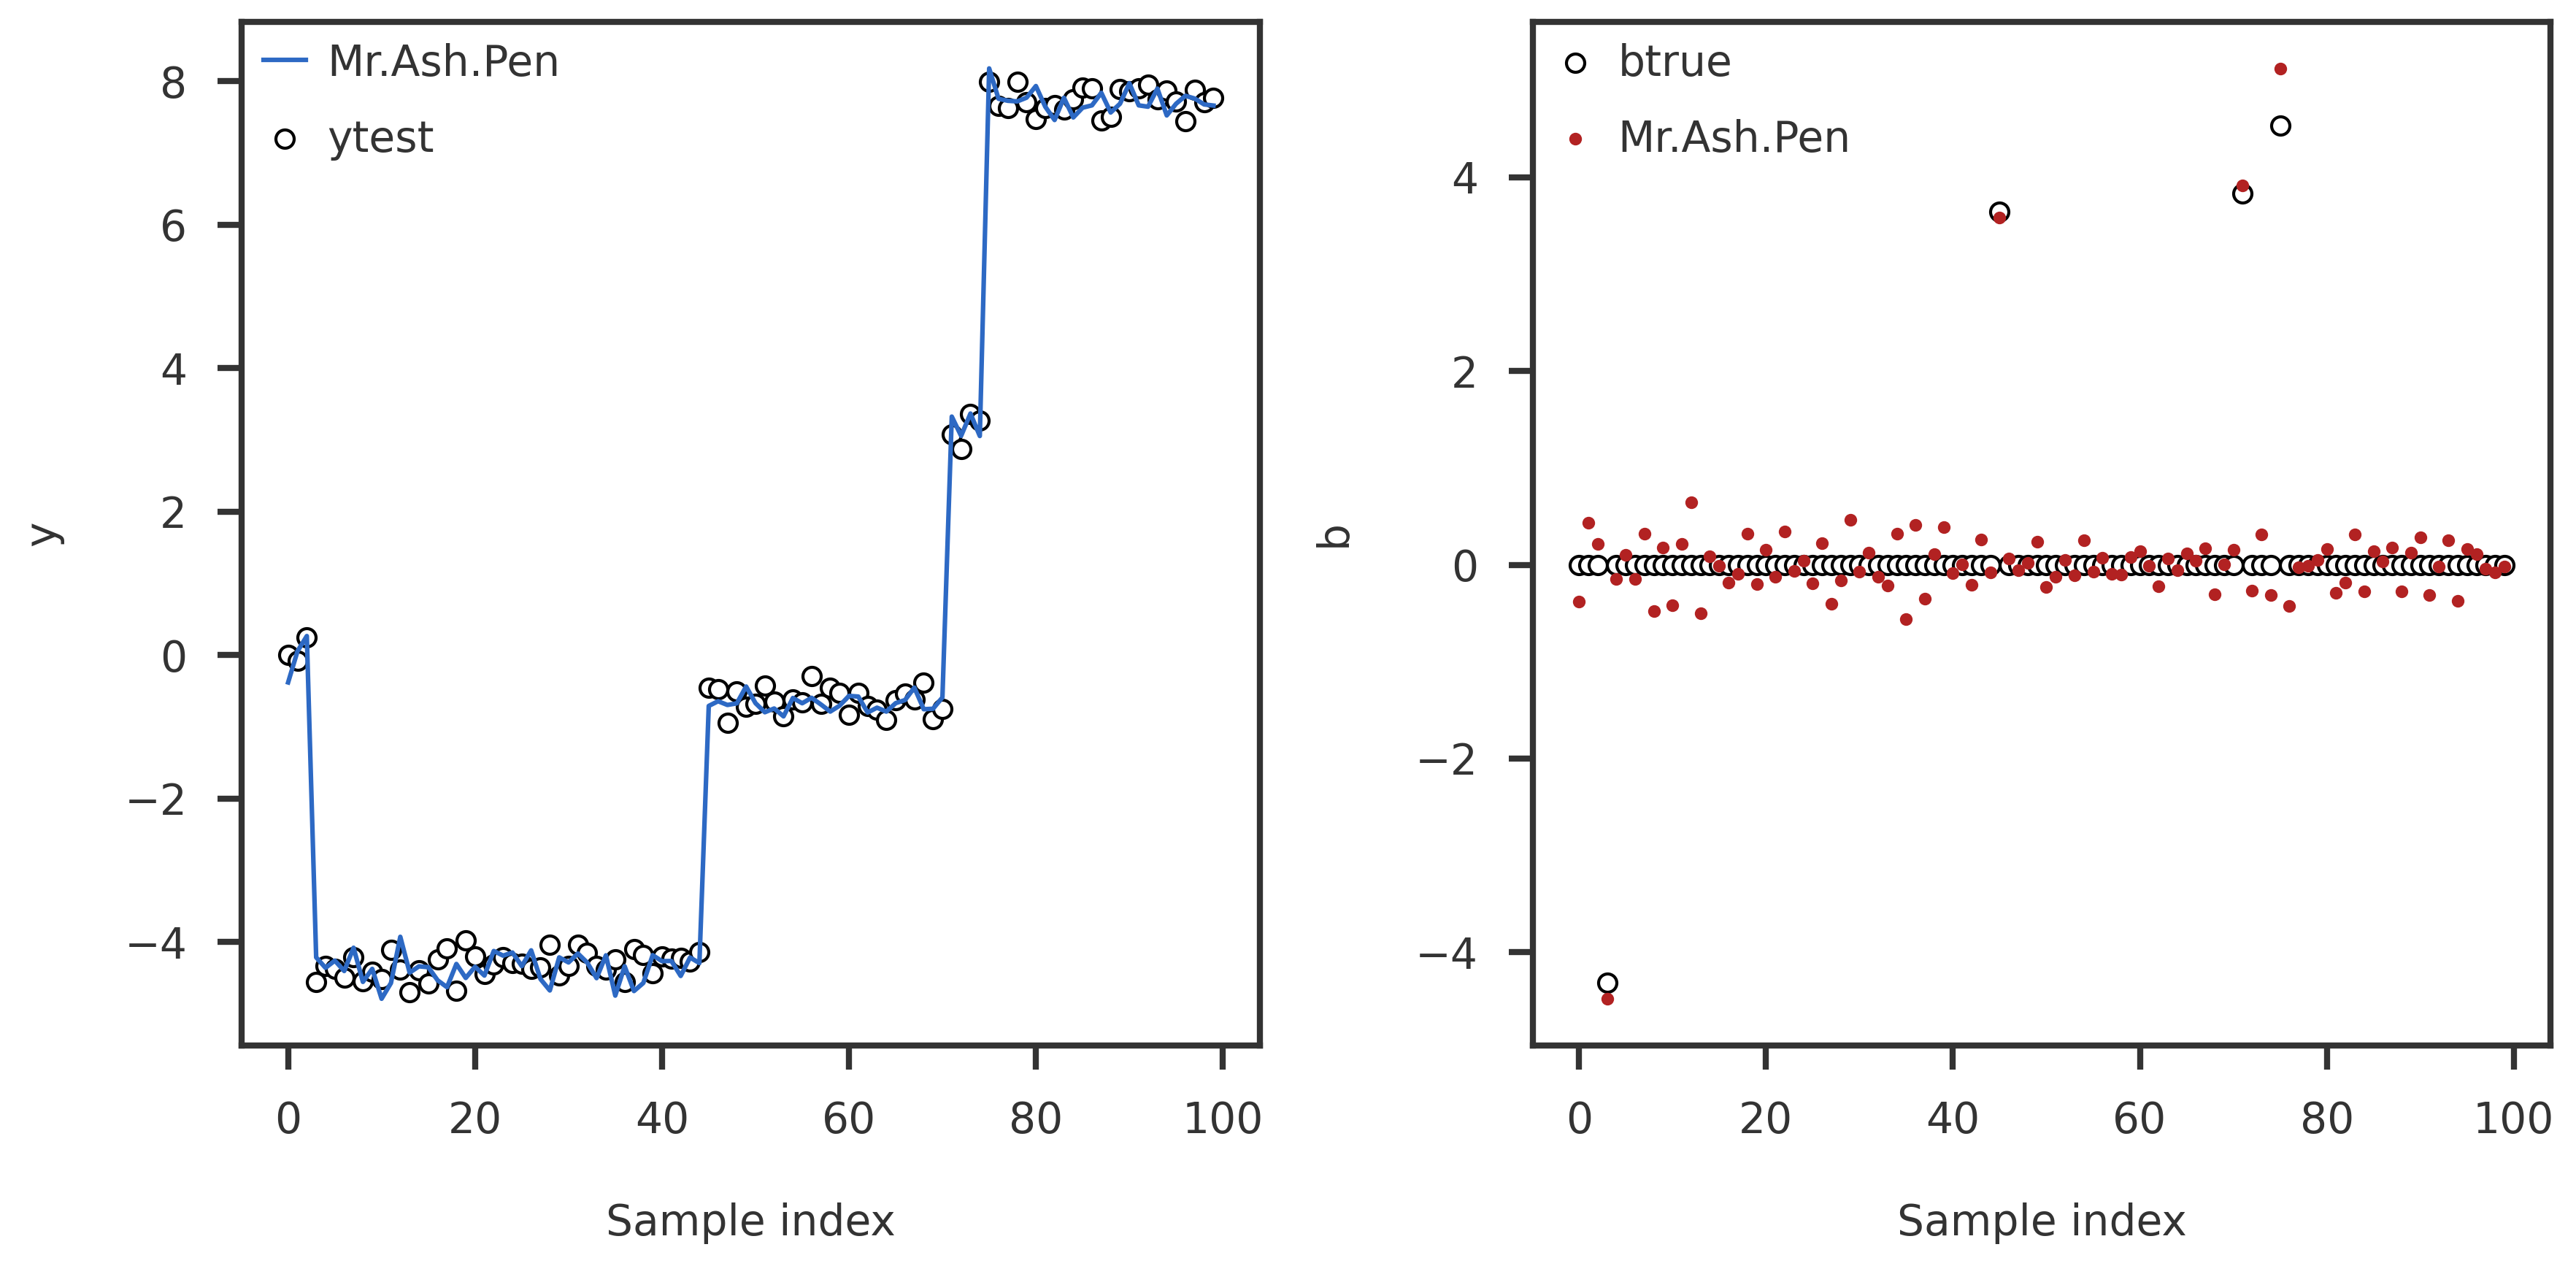

Optimized w:  [0.95852983 0.04147017 0.         0.         0.        ]


In [4]:
#collapse-hide

prior_grid = np.arange(k) * 10 + 1

print("Using w: ", w)
print("Using prior_grid: ", prior_grid)
print()

b0 = np.zeros(p)
plr_lbfgs = MrASHPen(optimize_w = True, debug = False)
plr_lbfgs.fit(X, y, prior_grid, binit = b0, winit = w, s2init = residual_var)

plot_trendfilter_mrashpen(X, y, beta, ytest, plr_lbfgs)

print("Optimized w: ", plr_lbfgs.prior)

## Failures

1. If the prior grid has a zero component (see below), then there is a "division-by-zero" error after a few updates. In the above example, I cheated using non-zero grid values.
2. To Do. Check if Definition 3.1 in `mixsqp` paper is applicable to $h(b, w)$.

**This has now been fixed.**

Using w:  [0.   0.25 0.25 0.25 0.25]
Using prior_grid:  [ 0 10 20 30 40]



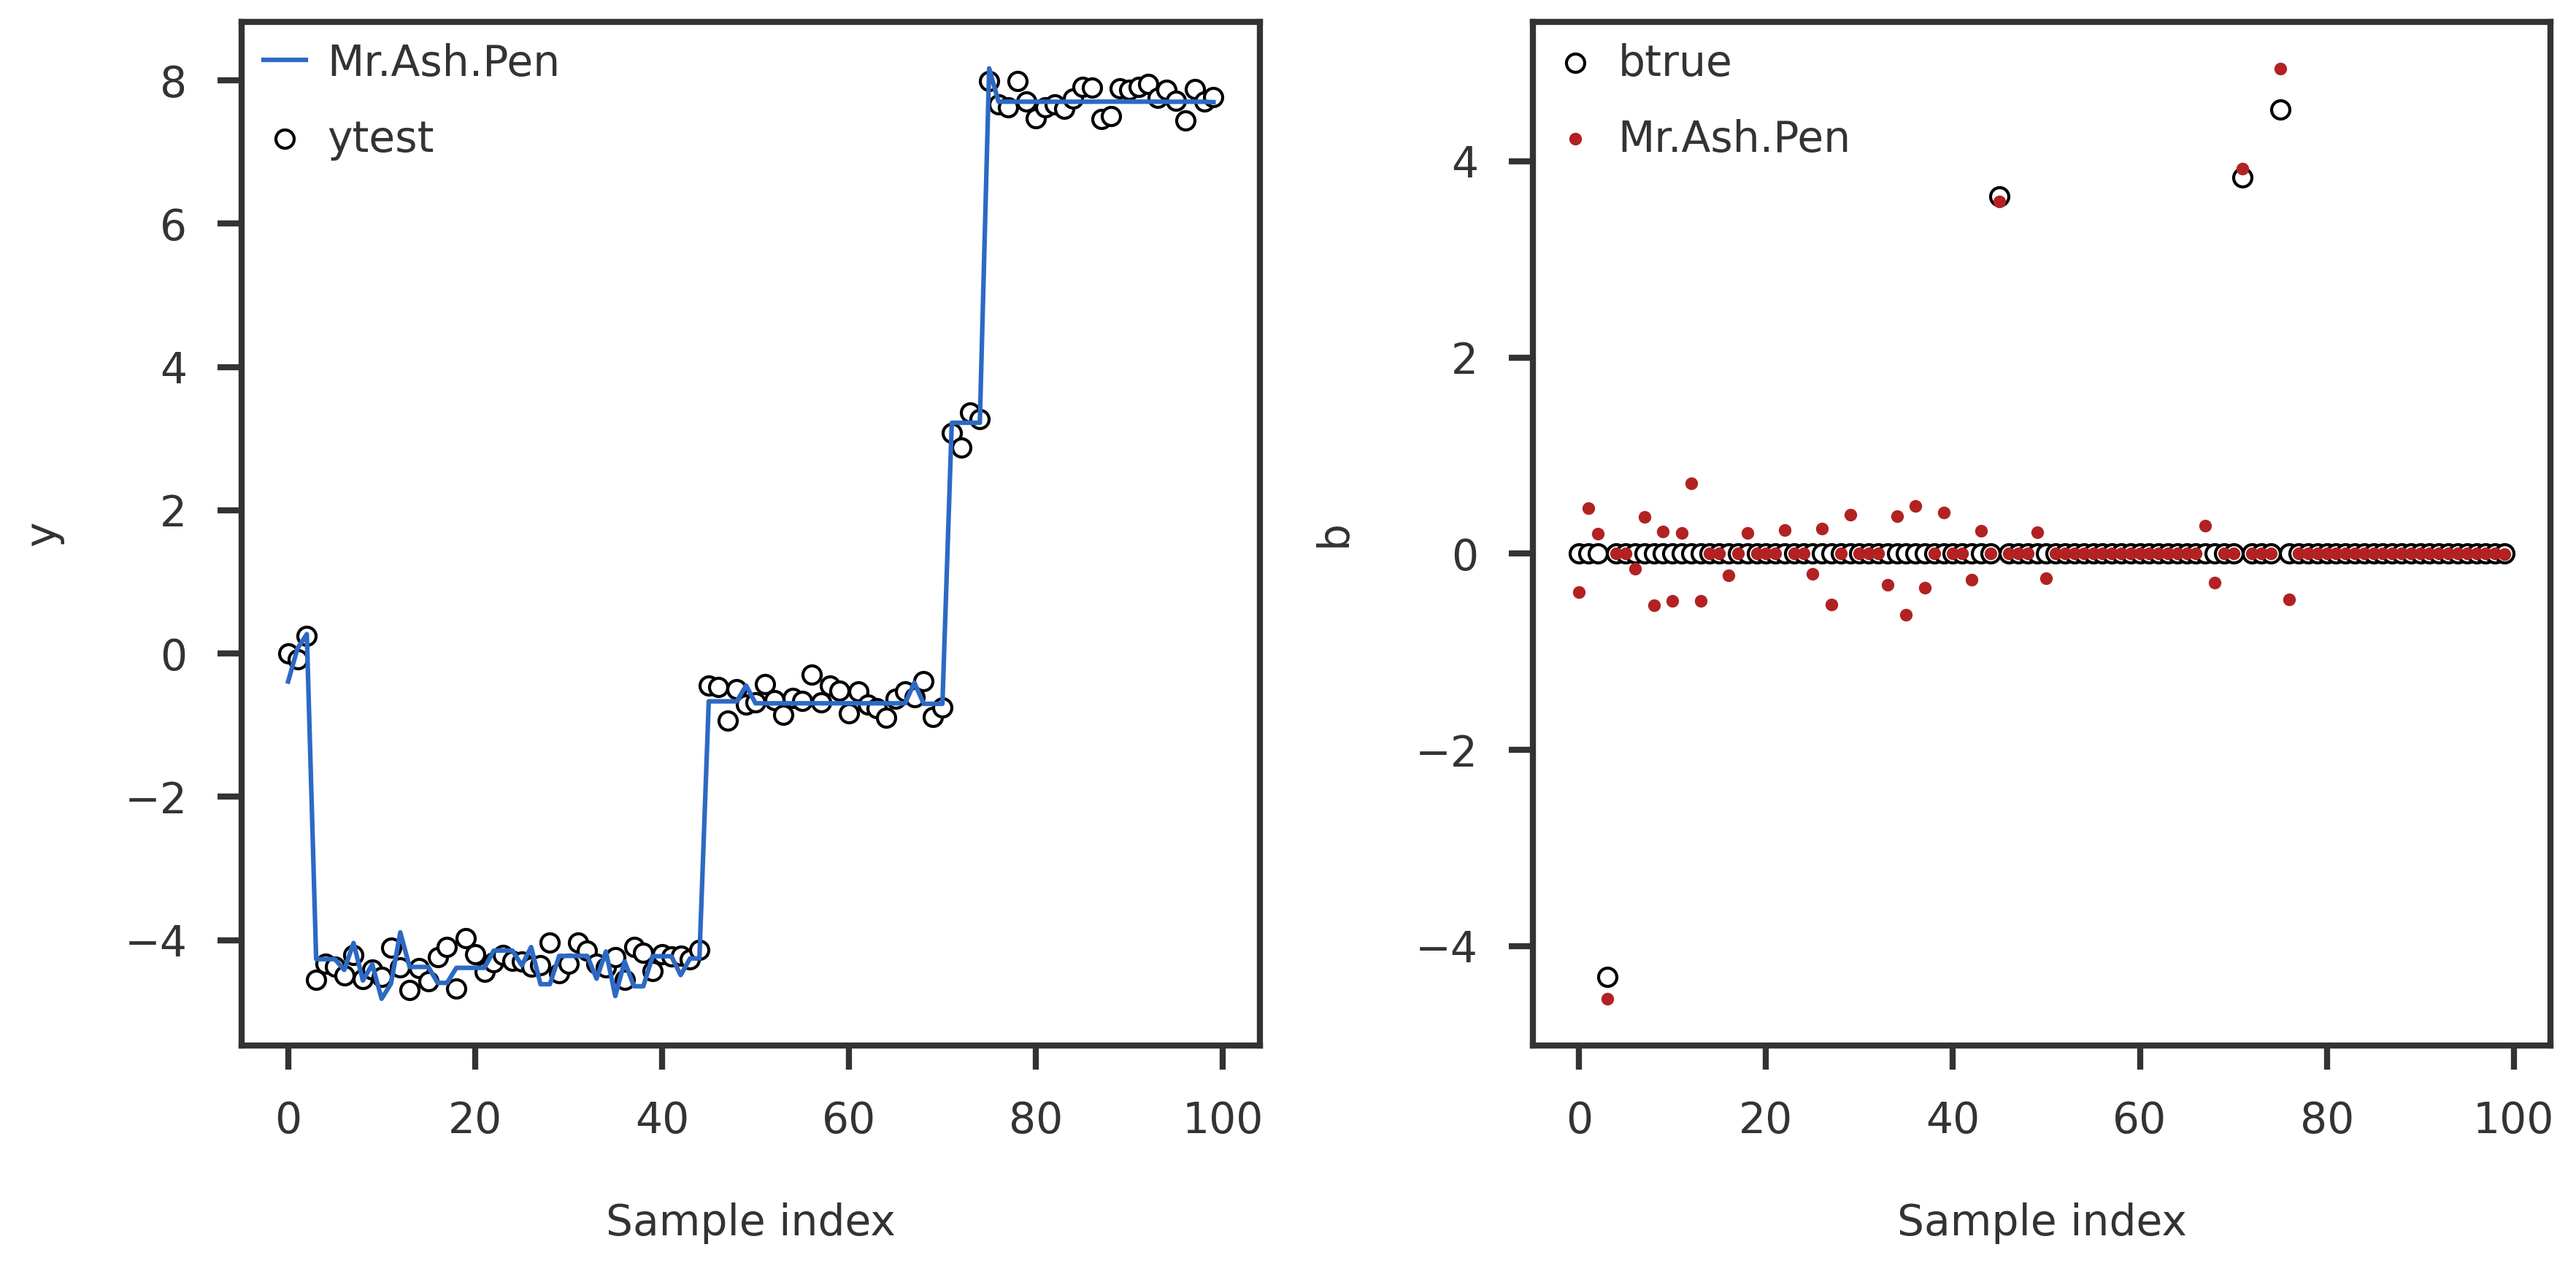

Optimized w:  [0.58908346 0.41091654 0.         0.         0.        ]


In [5]:
#collapse-hide

prior_grid = np.arange(k) * 10

print("Using w: ", w)
print("Using prior_grid: ", prior_grid)
print()

b0 = np.zeros(p)
plr_lbfgs = MrASHPen(optimize_w = False, debug = False)
plr_lbfgs.fit(X, y, prior_grid, binit = b0, winit = w, s2init = residual_var)


plr_lbfgs2 = MrASHPen(optimize_w = True, debug = False)
plr_lbfgs2.fit(X, y, prior_grid, binit = plr_lbfgs.coef, winit = w, s2init = residual_var)

plot_trendfilter_mrashpen(X, y, beta, ytest, plr_lbfgs2)

print("Optimized w: ", plr_lbfgs2.prior)

### Optimize $w_k$ using EM 

This requires penalized regression to be run multiple times.

Using w:  [0.   0.25 0.25 0.25 0.25]
Using prior_grid:  [ 0 10 20 30 40]



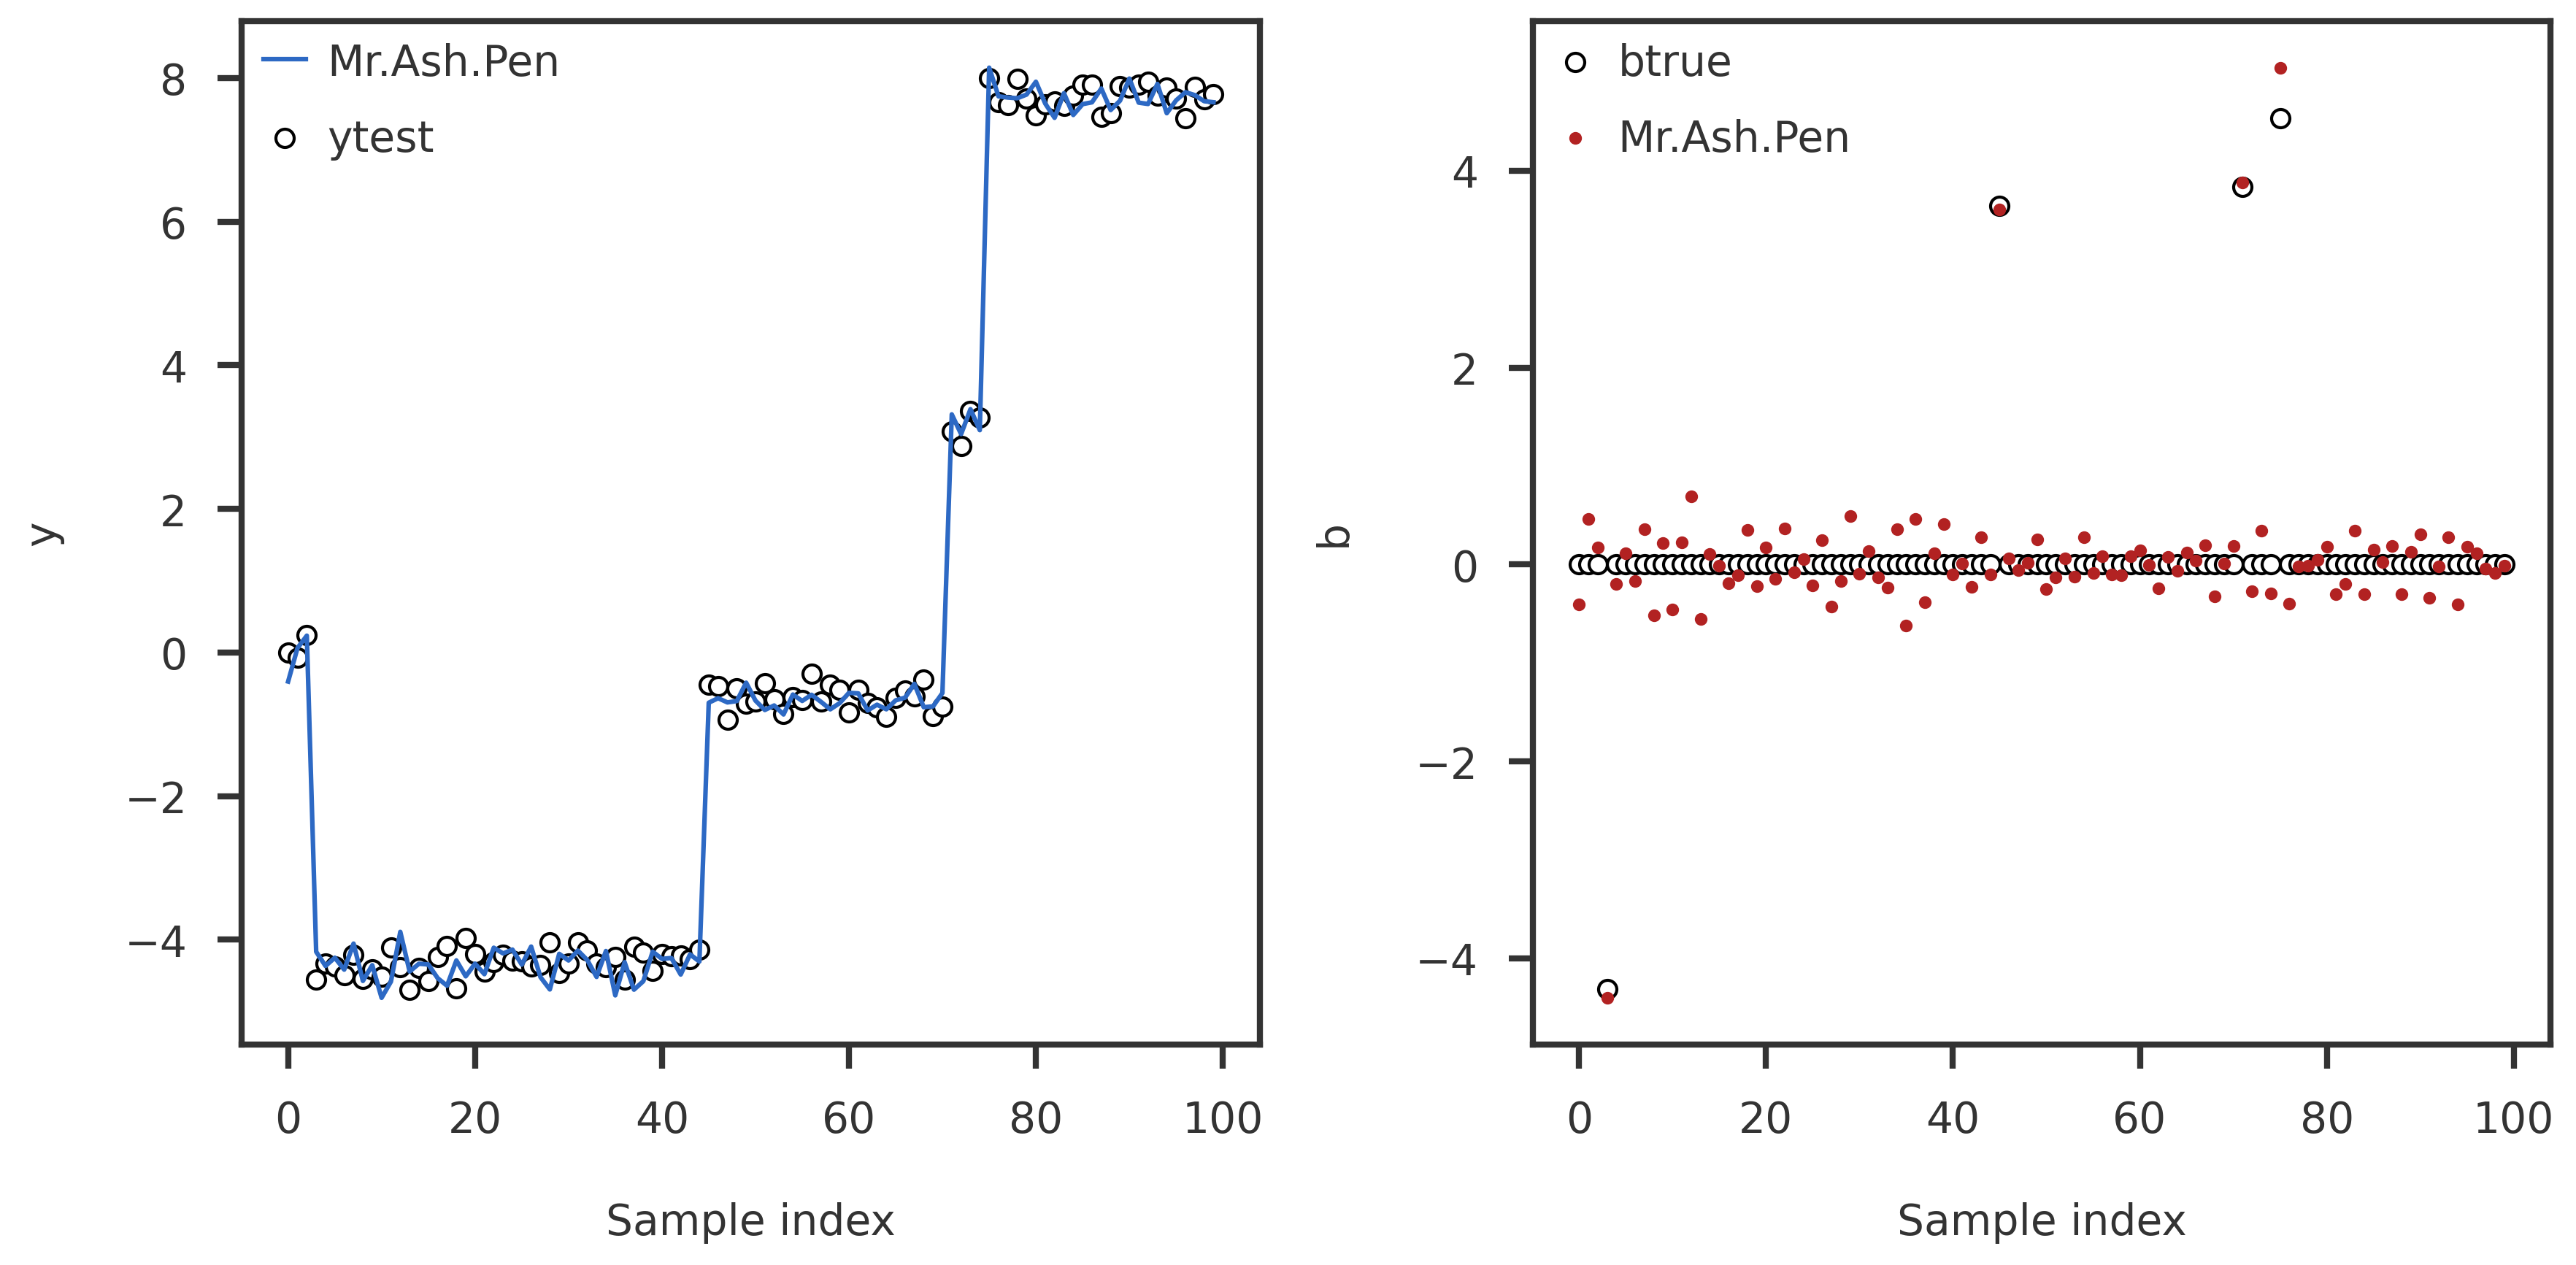

Optimized w:  [0.00000000e+00 1.00000000e+00 1.08890503e-30 2.84942223e-48
 9.34048265e-61]


In [6]:
#collapse-hide

prior_grid = np.arange(k) * 10

print("Using w: ", w)
print("Using prior_grid: ", prior_grid)
print()

b0 = np.zeros(p)
plr_lbfgs = MrASHPen(optimize_w = True, debug = False)
plr_lbfgs.ebfit(X, y, prior_grid, binit = b0, winit = w, s2init = residual_var)

plot_trendfilter_mrashpen(X, y, beta, ytest, plr_lbfgs)

print("Optimized w: ", plr_lbfgs.prior)

Use a relaxed prior grid

Using w:  [0.   0.25 0.25 0.25 0.25]
Using prior_grid:  [0 1 2 3 4]



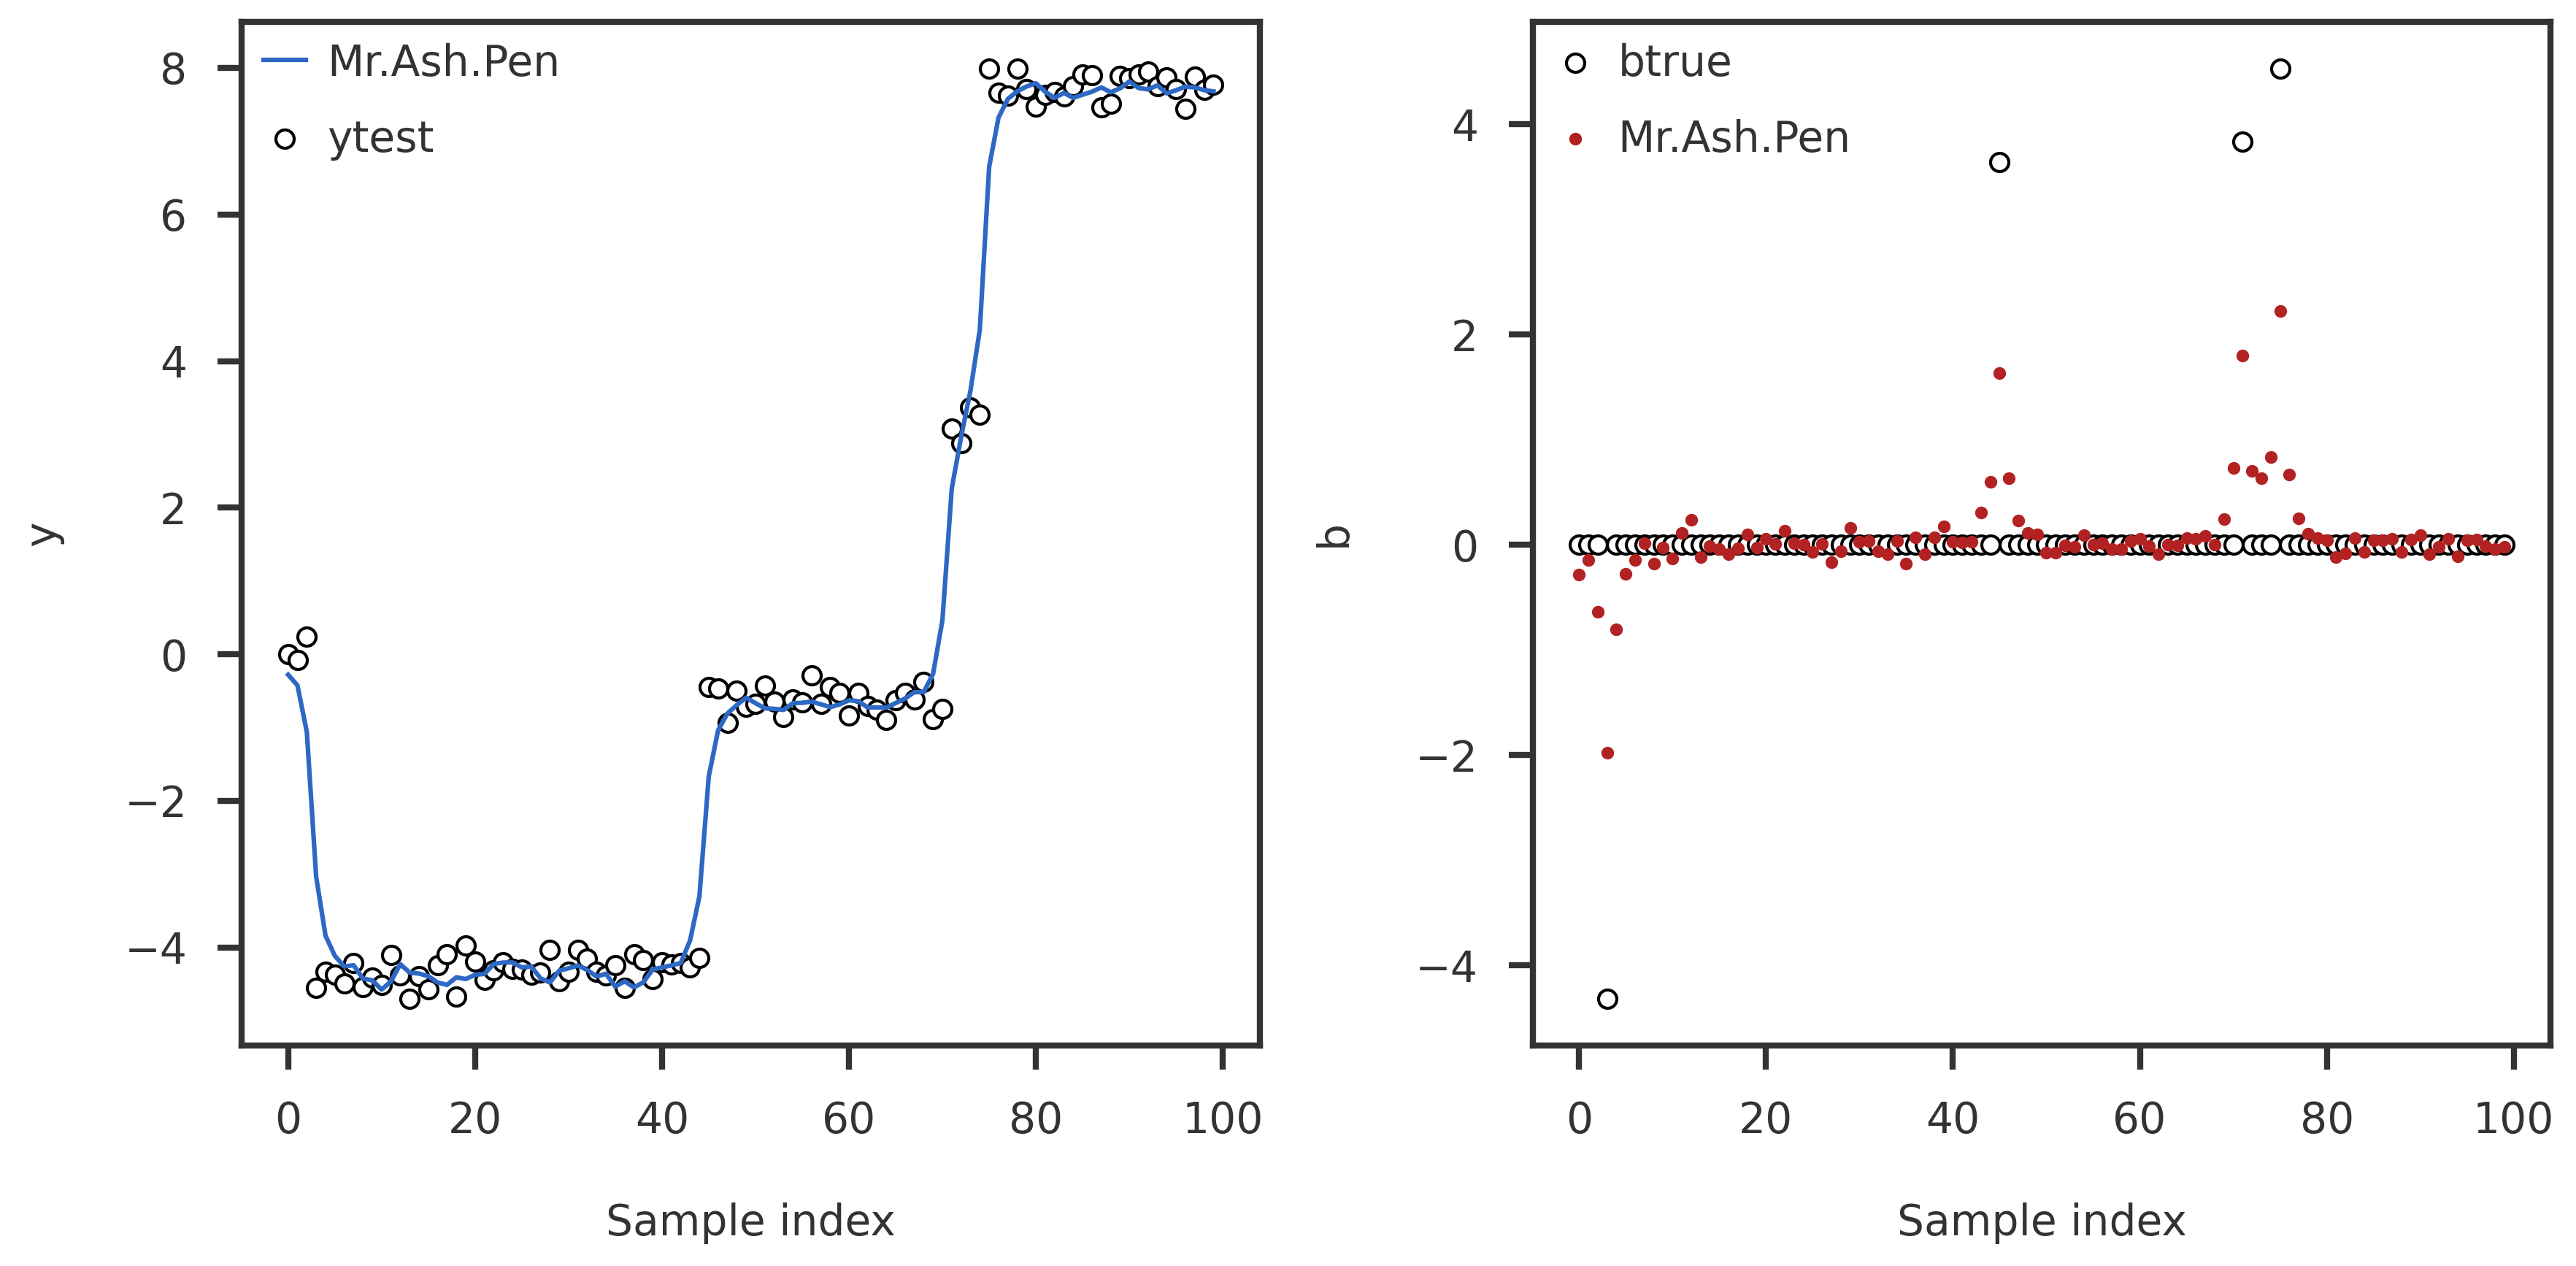

Optimized w:  [0.00000000e+00 1.00000000e+00 1.31302307e-24 6.43065533e-40
 1.95905088e-51]


In [7]:
#collapse-hide

prior_grid = np.arange(k)

print("Using w: ", w)
print("Using prior_grid: ", prior_grid)
print()

b0 = np.zeros(p)
plr_lbfgs = MrASHPen(optimize_w = True, debug = False)
plr_lbfgs.ebfit(X, y, prior_grid, binit = b0, winit = w, s2init = residual_var)

plot_trendfilter_mrashpen(X, y, beta, ytest, plr_lbfgs)

print("Optimized w: ", plr_lbfgs.prior)

What happens if I use higher order basis for fitting?

Using w:  [0.   0.25 0.25 0.25 0.25]
Using prior_grid:  [ 0 10 20 30 40]



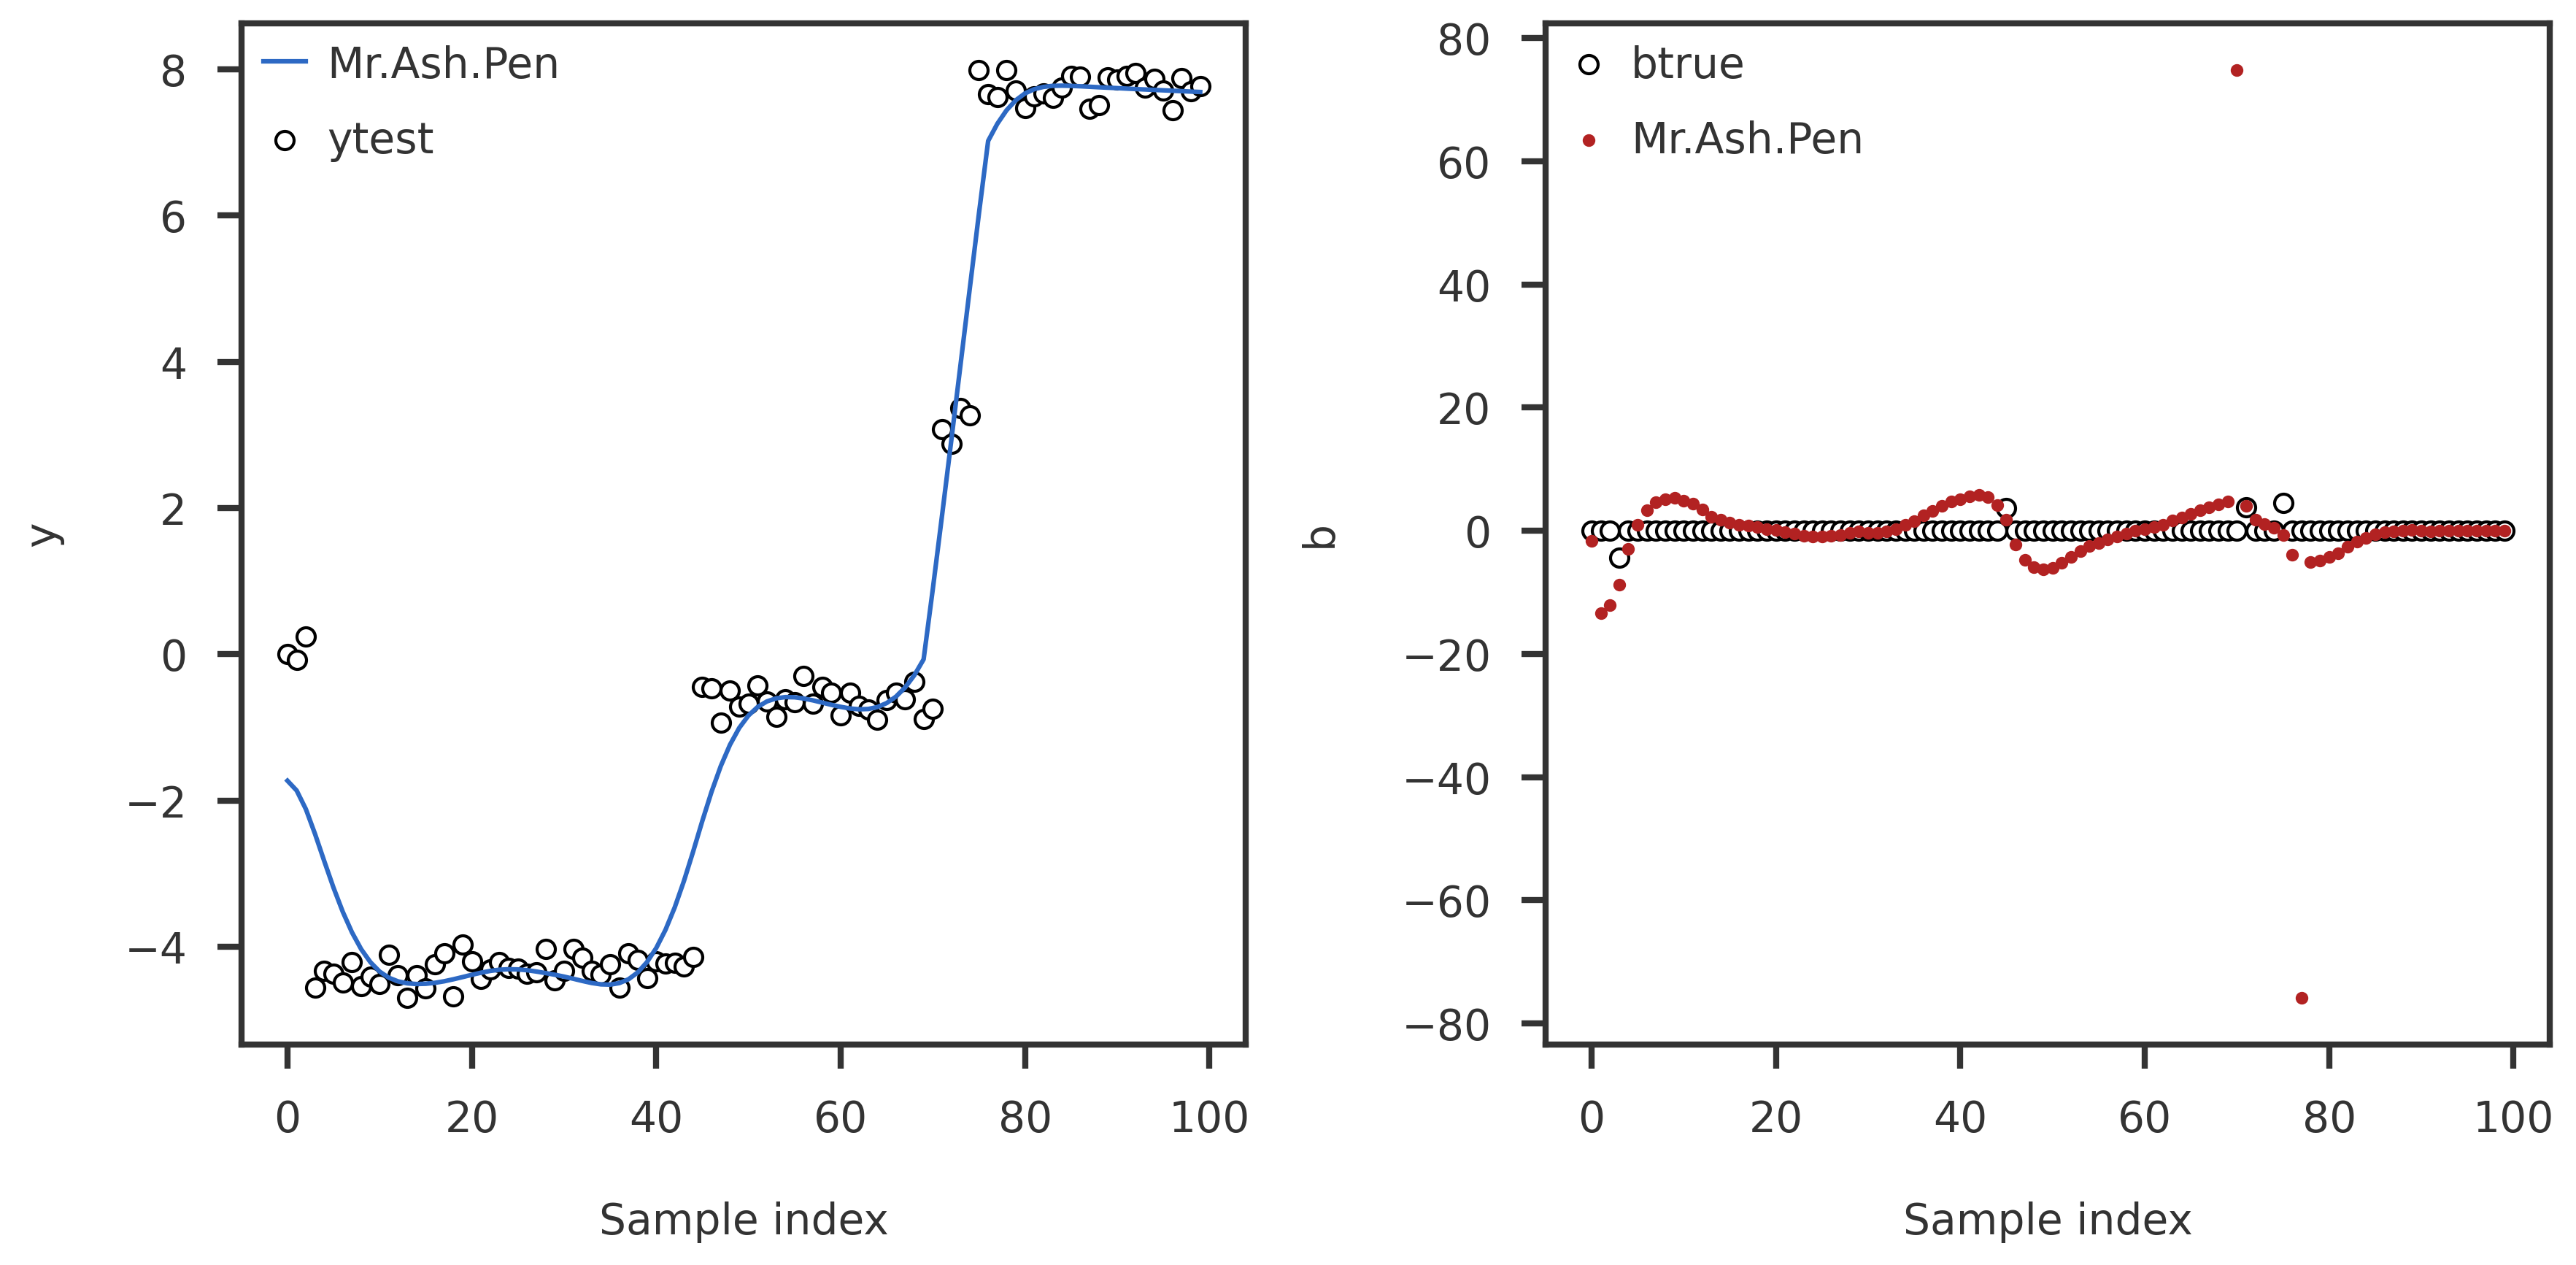

Optimized w:  [0.00000000e+00 9.72718172e-01 7.94587192e-28 7.73959945e-23
 2.72818284e-02]


In [8]:
#collapse-hide

prior_grid = np.arange(k) * 10

print("Using w: ", w)
print("Using prior_grid: ", prior_grid)
print()

b0 = np.zeros(p)
X_alt = simulate.trend_filtering_basis(n, p, 1)

plr_lbfgs = MrASHPen(optimize_w = True, debug = False)
plr_lbfgs.ebfit(X_alt, y, prior_grid, binit = b0, winit = w, s2init = residual_var)

plot_trendfilter_mrashpen(X_alt, y, beta, ytest, plr_lbfgs)

print("Optimized w: ", plr_lbfgs.prior)

## Trendfiltering with less sparsity (p_causal = 20)

Initial w:  [0.   0.25 0.25 0.25 0.25]
Prior_grid:  [ 0 10 20 30 40]



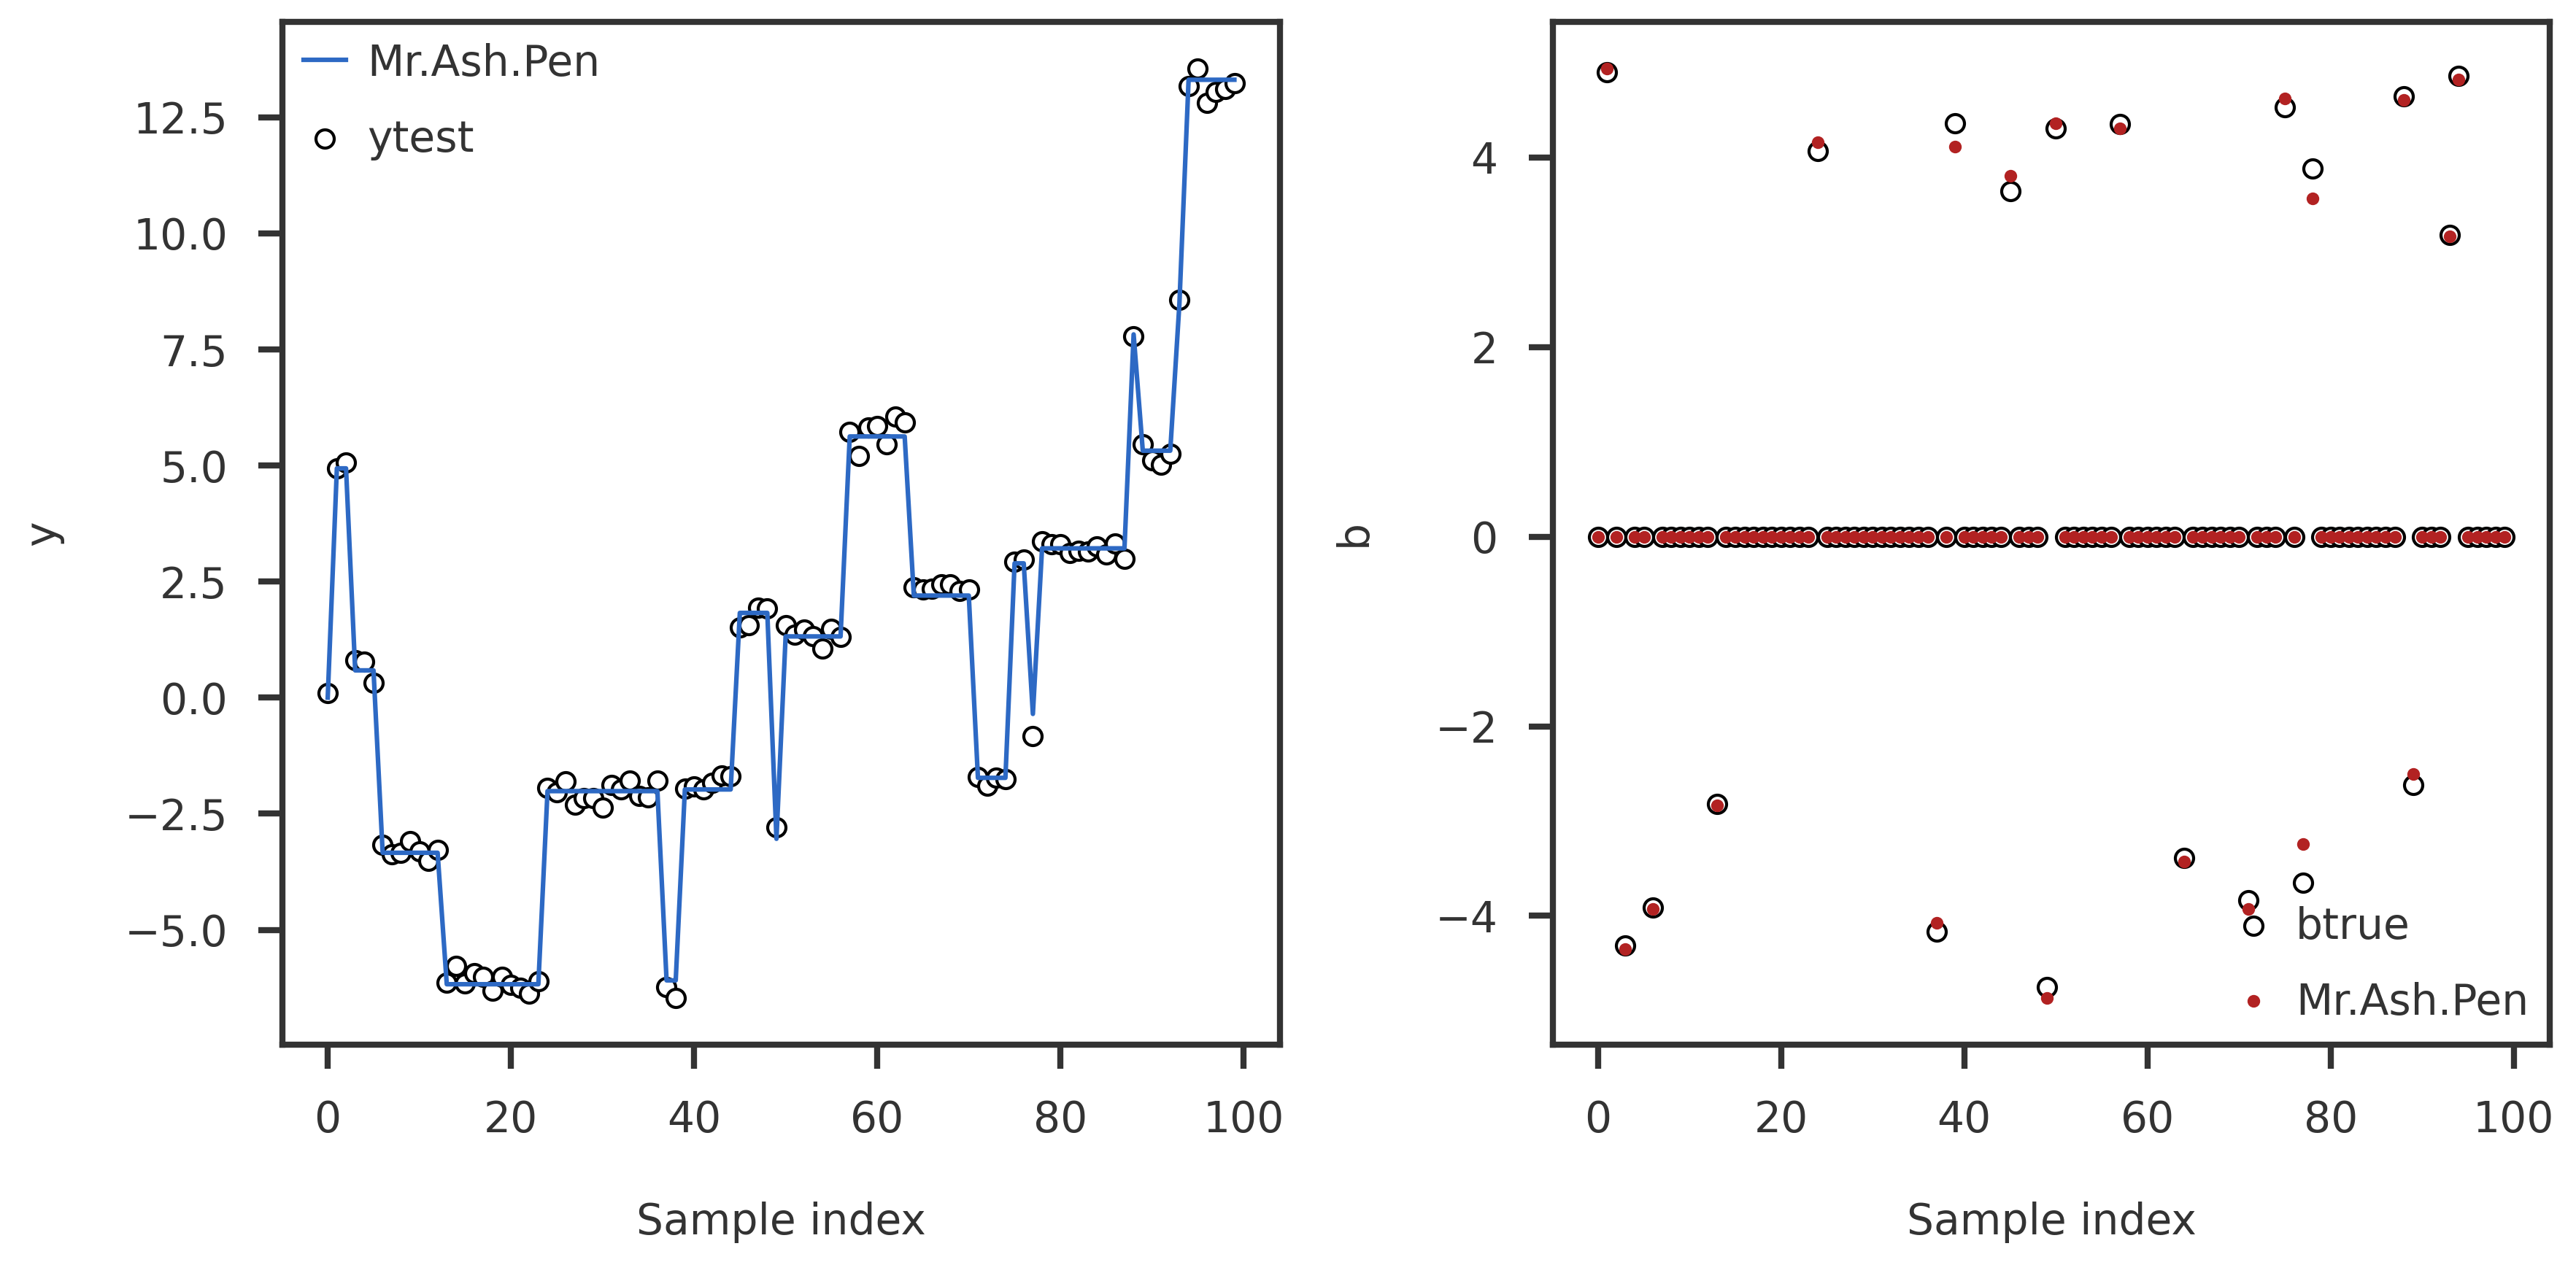

Optimized w:  [0.7992899 0.2007101 0.        0.        0.       ]


In [9]:
#collapse-hide

n = 100
p = 100
p_causal = 20
snr = 20
k = 5

X, y, Xtest, ytest, beta, se = simulate.changepoint_predictors (n, p, p_causal, snr, 
                                                                k = 0, signal = 'gamma', seed = 20)

residual_var = se * se

## Prior
w = np.zeros(k)
w[0] = 0
w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
w[k-1] = 1 - np.sum(w)
prior_grid = np.arange(k) * 10

print("Initial w: ", w)
print("Prior_grid: ", prior_grid)
print()

b0 = np.zeros(p)
plr_lbfgs = MrASHPen(optimize_w = True, debug = False)
plr_lbfgs.fit(X, y, prior_grid, binit = b0, winit = w, s2init = residual_var)

plot_trendfilter_mrashpen(X, y, beta, ytest, plr_lbfgs)

print("Optimized w: ", plr_lbfgs.prior)

## Failures

1. If I initialize with $w_0 > 0$, then the results do not converge. For example, in the example below, I use $w_k = 0.01$.
**This has been fixed.**

Initial w:  [0.01   0.2475 0.2475 0.2475 0.2475]
Prior_grid:  [ 0 10 20 30 40]



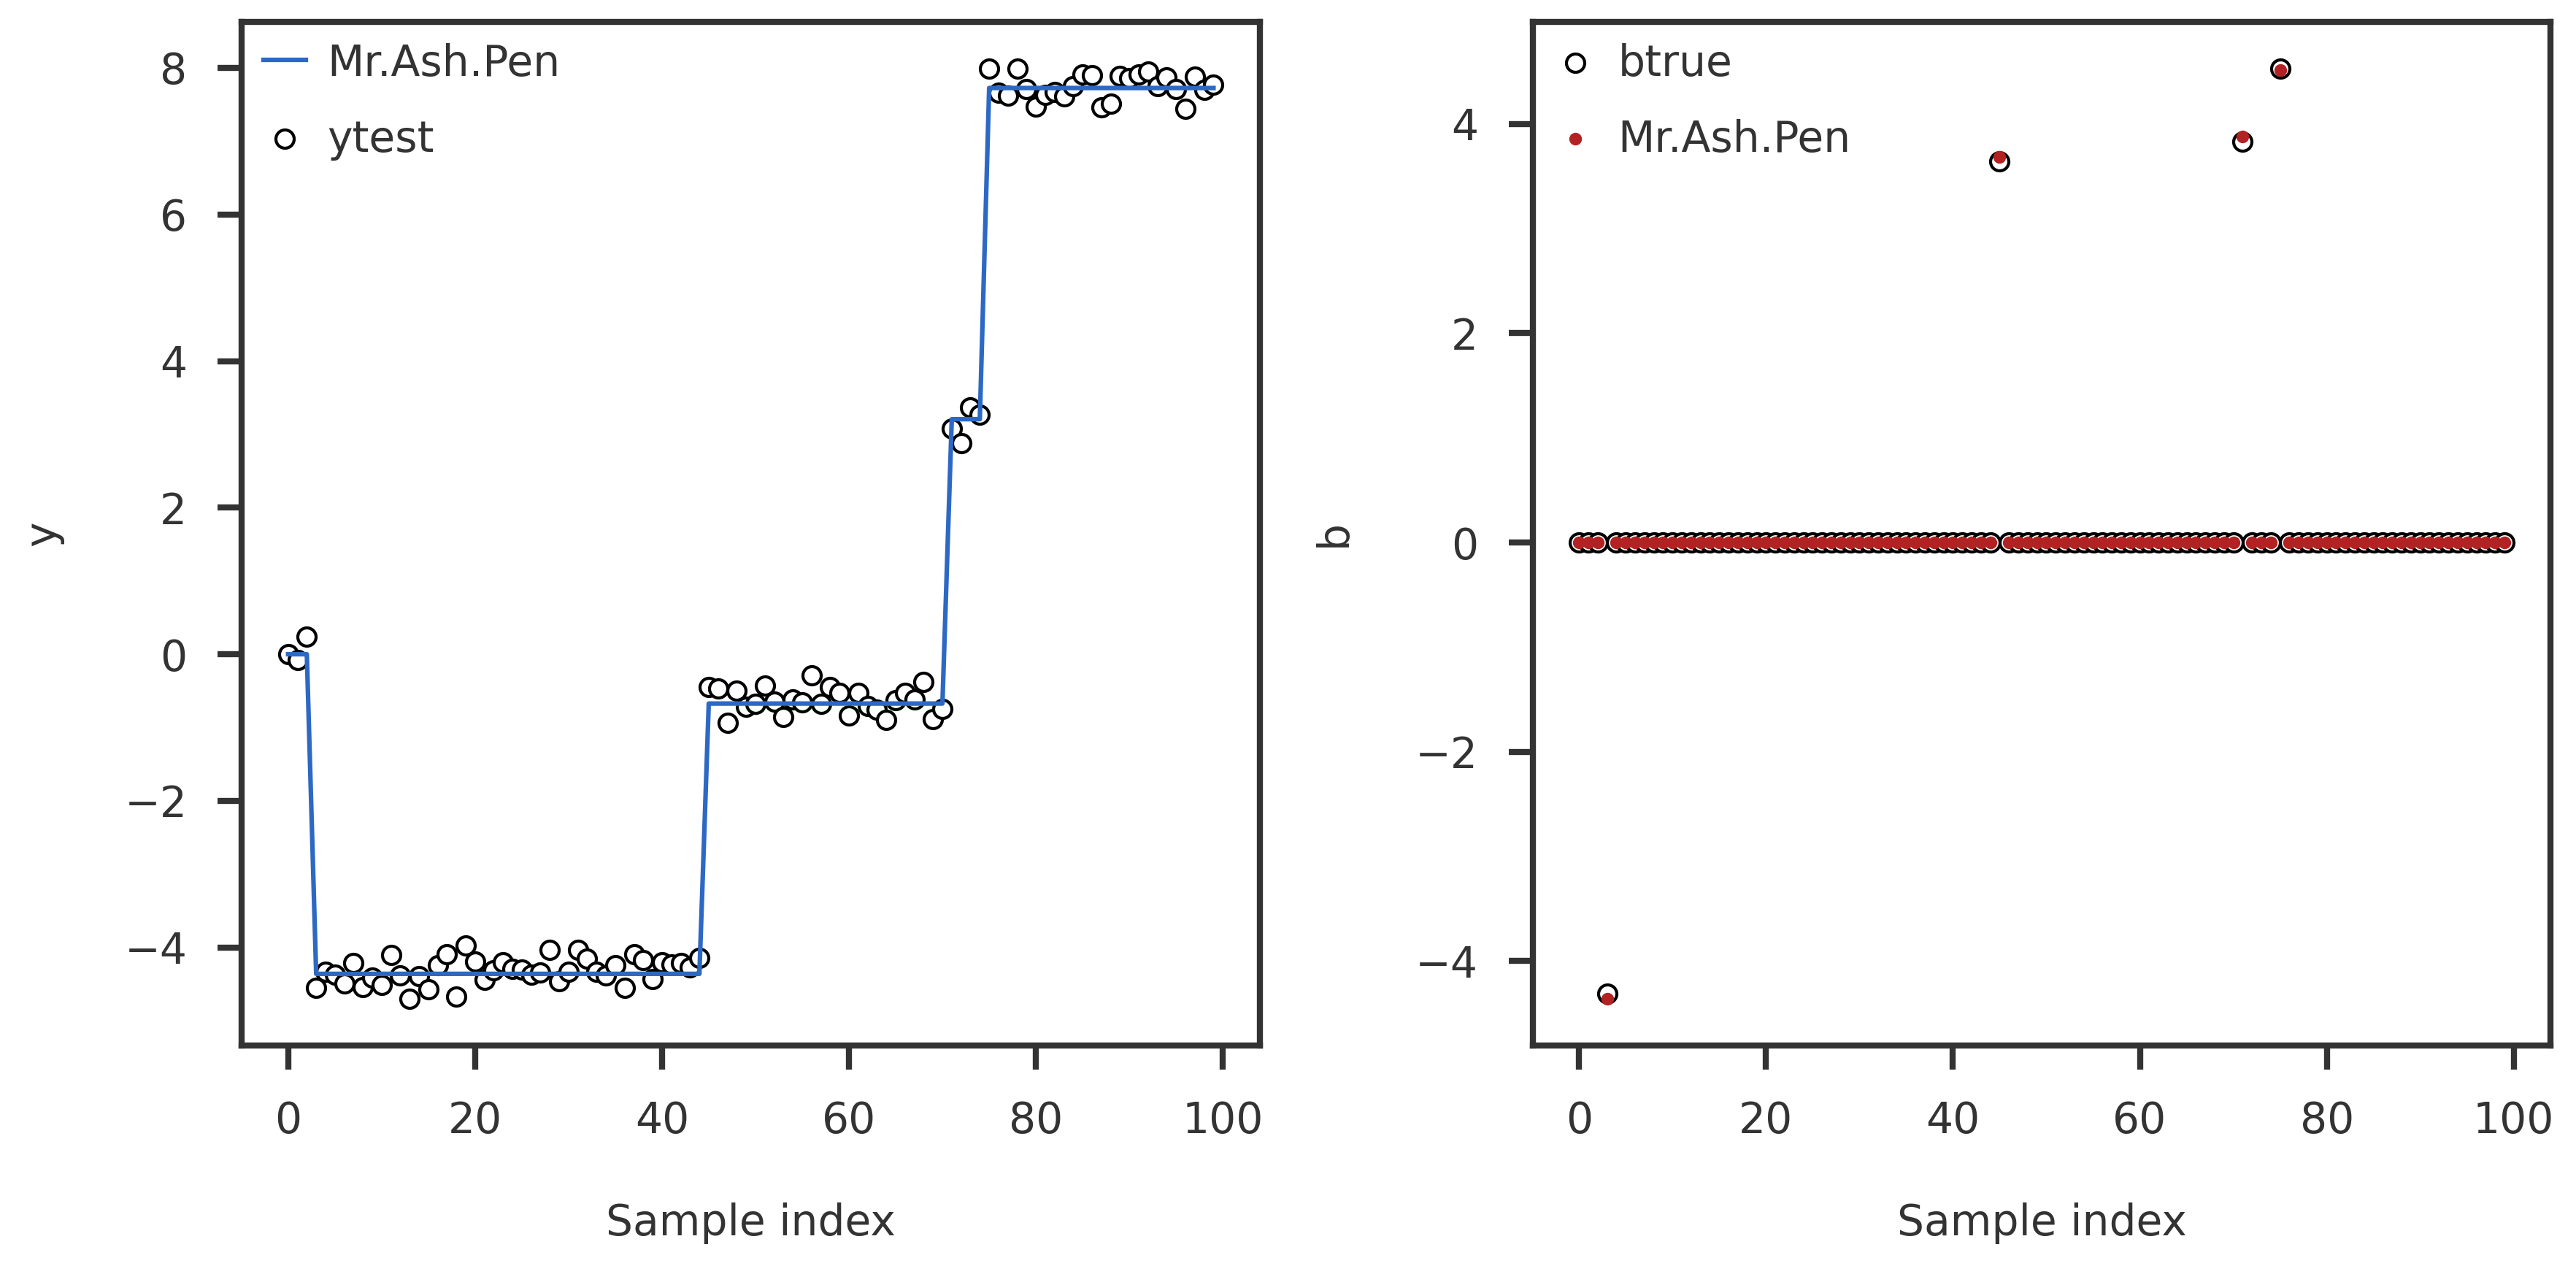

Optimized w:  [0.95973248 0.04026752 0.         0.         0.        ]


In [10]:
#collapse-hide

n = 100
p = 100
p_causal = 4
snr = 20
k = 5

X, y, Xtest, ytest, beta, se = simulate.changepoint_predictors (n, p, p_causal, snr, 
                                                                k = 0, signal = 'gamma', seed = 20)

residual_var = se * se

## Prior
w = np.zeros(k)
w[0] = 0.01
w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
w[k-1] = 1 - np.sum(w)
prior_grid = np.arange(k) * 10

print("Initial w: ", w)
print("Prior_grid: ", prior_grid)
print()

b0 = np.zeros(p)
plr_lbfgs = MrASHPen(optimize_w = True, debug = False)
plr_lbfgs.fit(X, y, prior_grid, binit = b0, winit = w, s2init = residual_var)

plot_trendfilter_mrashpen(X, y, beta, ytest, plr_lbfgs)

print("Optimized w: ", plr_lbfgs.prior)

Initial w:  [0.01   0.2475 0.2475 0.2475 0.2475]
Prior_grid:  [ 0 10 20 30 40]



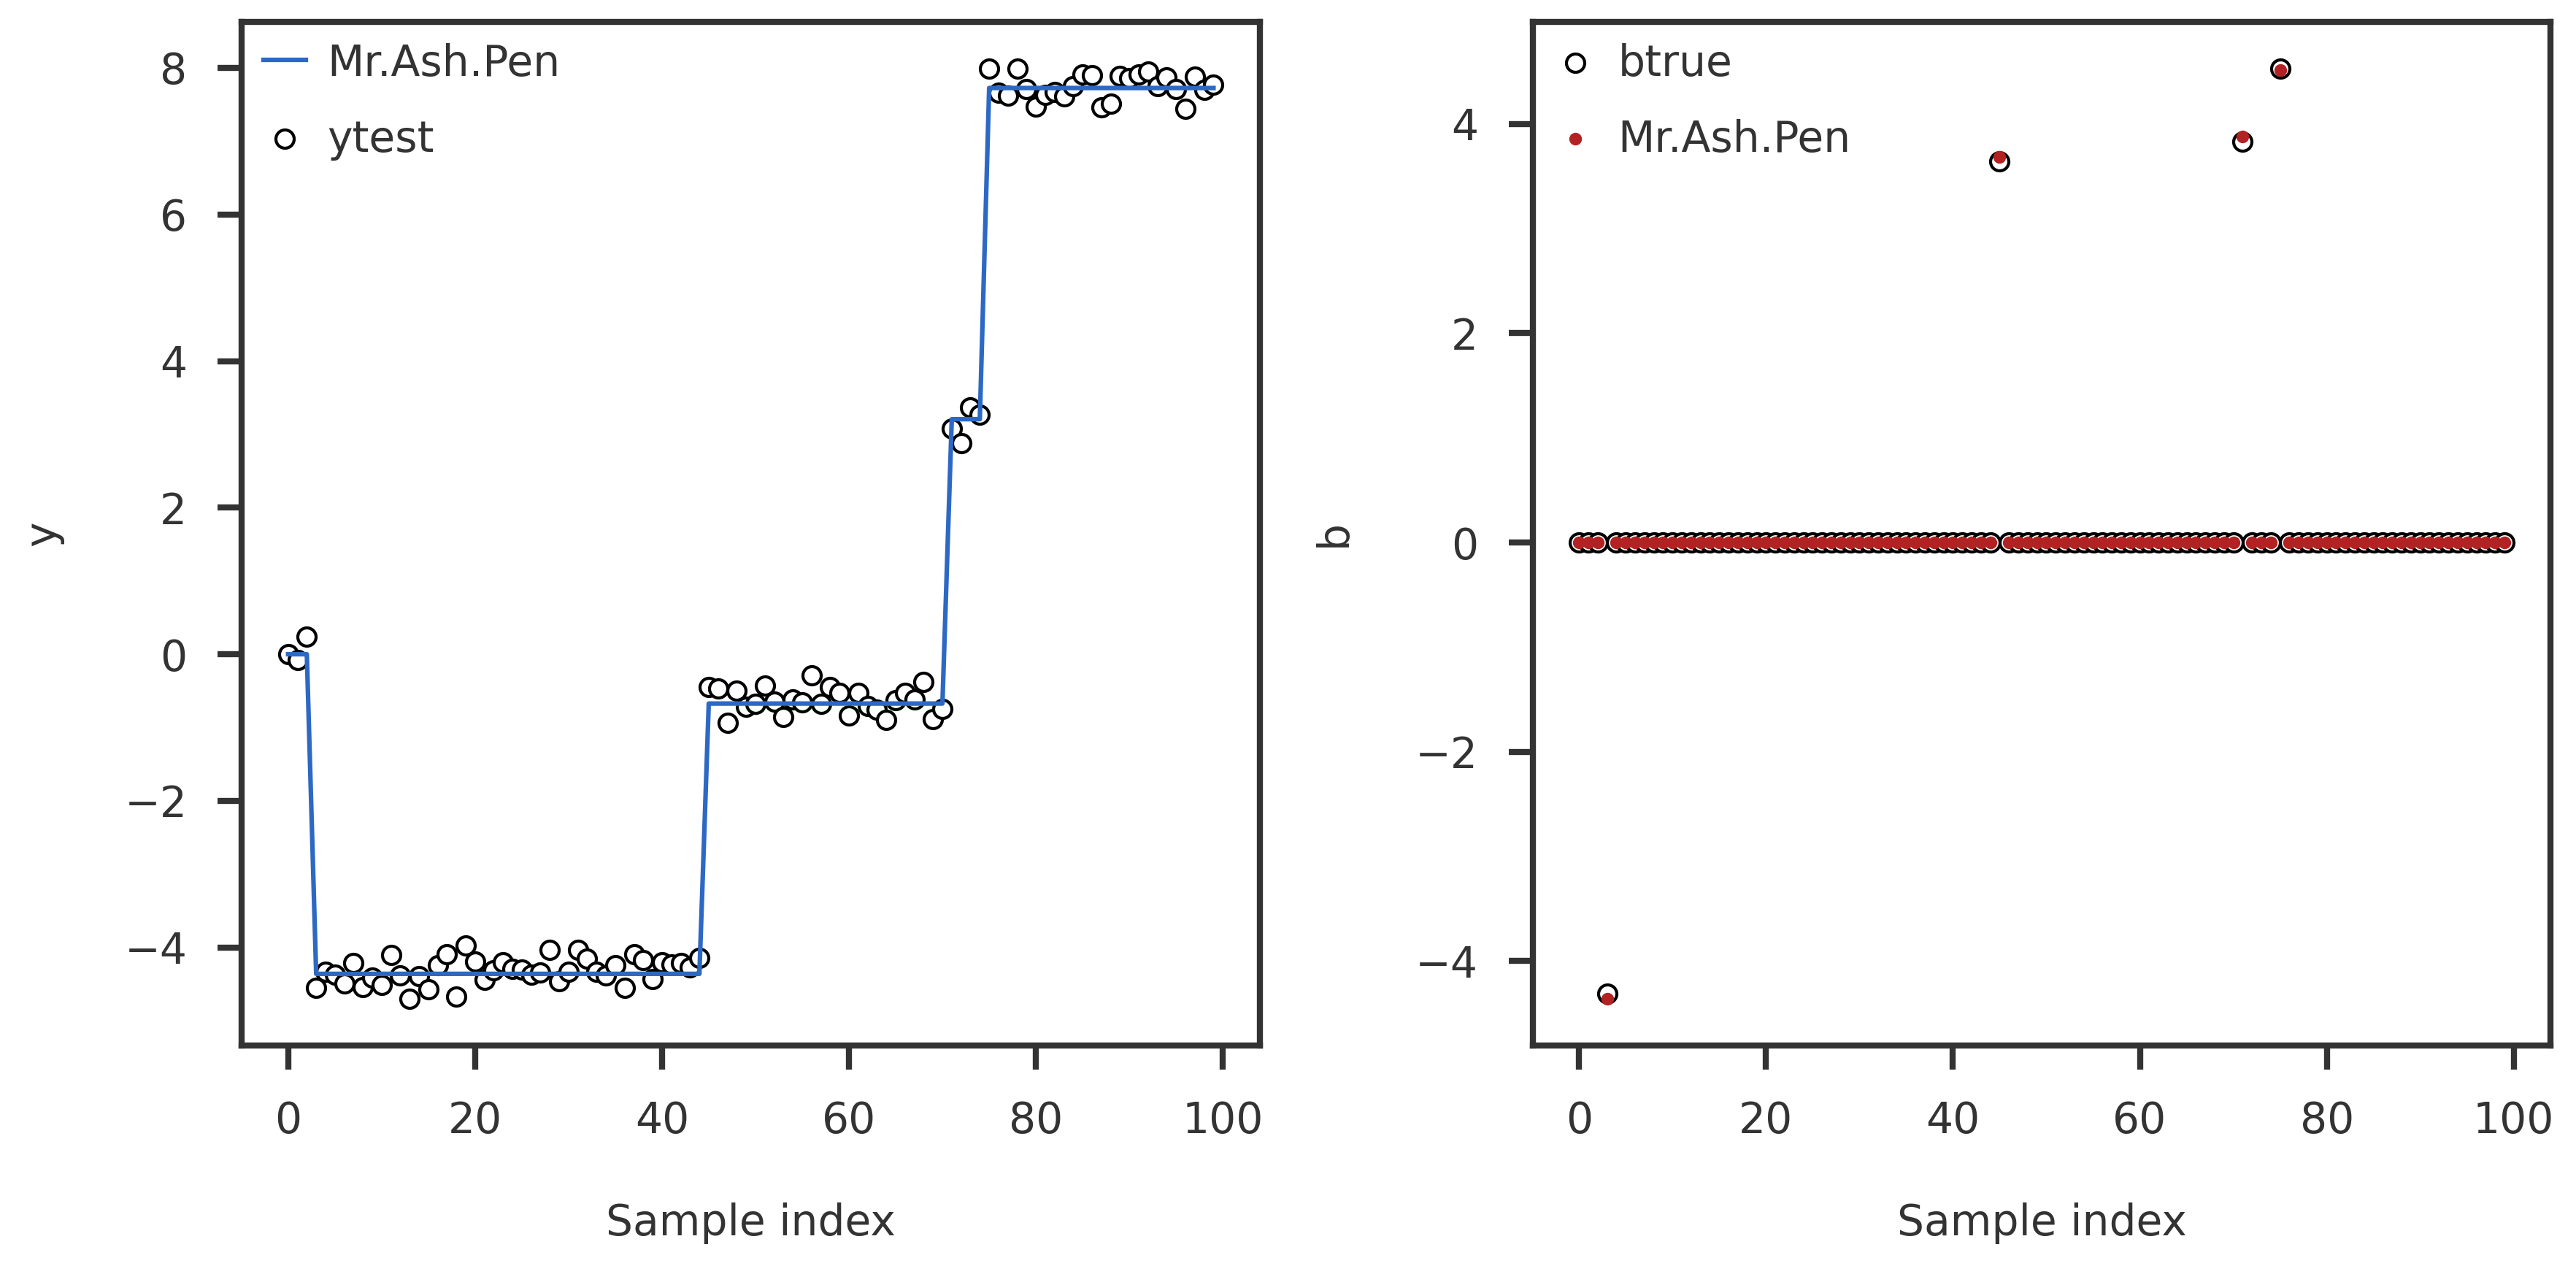

Optimized w:  [0.95973248 0.04026752 0.         0.         0.        ]


In [11]:
#collapse-hide

n = 100
p = 100
p_causal = 4
snr = 20
k = 5

X, y, Xtest, ytest, beta, se = simulate.changepoint_predictors (n, p, p_causal, snr, 
                                                                k = 0, signal = 'gamma', seed = 20)

residual_var = se * se

## Prior
w = np.zeros(k)
w[0] = 0.01
w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
w[k-1] = 1 - np.sum(w)
prior_grid = np.arange(k) * 10

print("Initial w: ", w)
print("Prior_grid: ", prior_grid)
print()

b0 = np.zeros(p)
plr_lbfgs = MrASHPen(optimize_w = True, debug = False, witer = 0)
plr_lbfgs.fit(X, y, prior_grid, binit = b0, winit = w, s2init = residual_var)

plot_trendfilter_mrashpen(X, y, beta, ytest, plr_lbfgs)

print("Optimized w: ", plr_lbfgs.prior)

## Example of higher order trendfiltering

Initial w:  [0.   0.25 0.25 0.25 0.25]
Prior_grid:  [0 1 2 3 4]



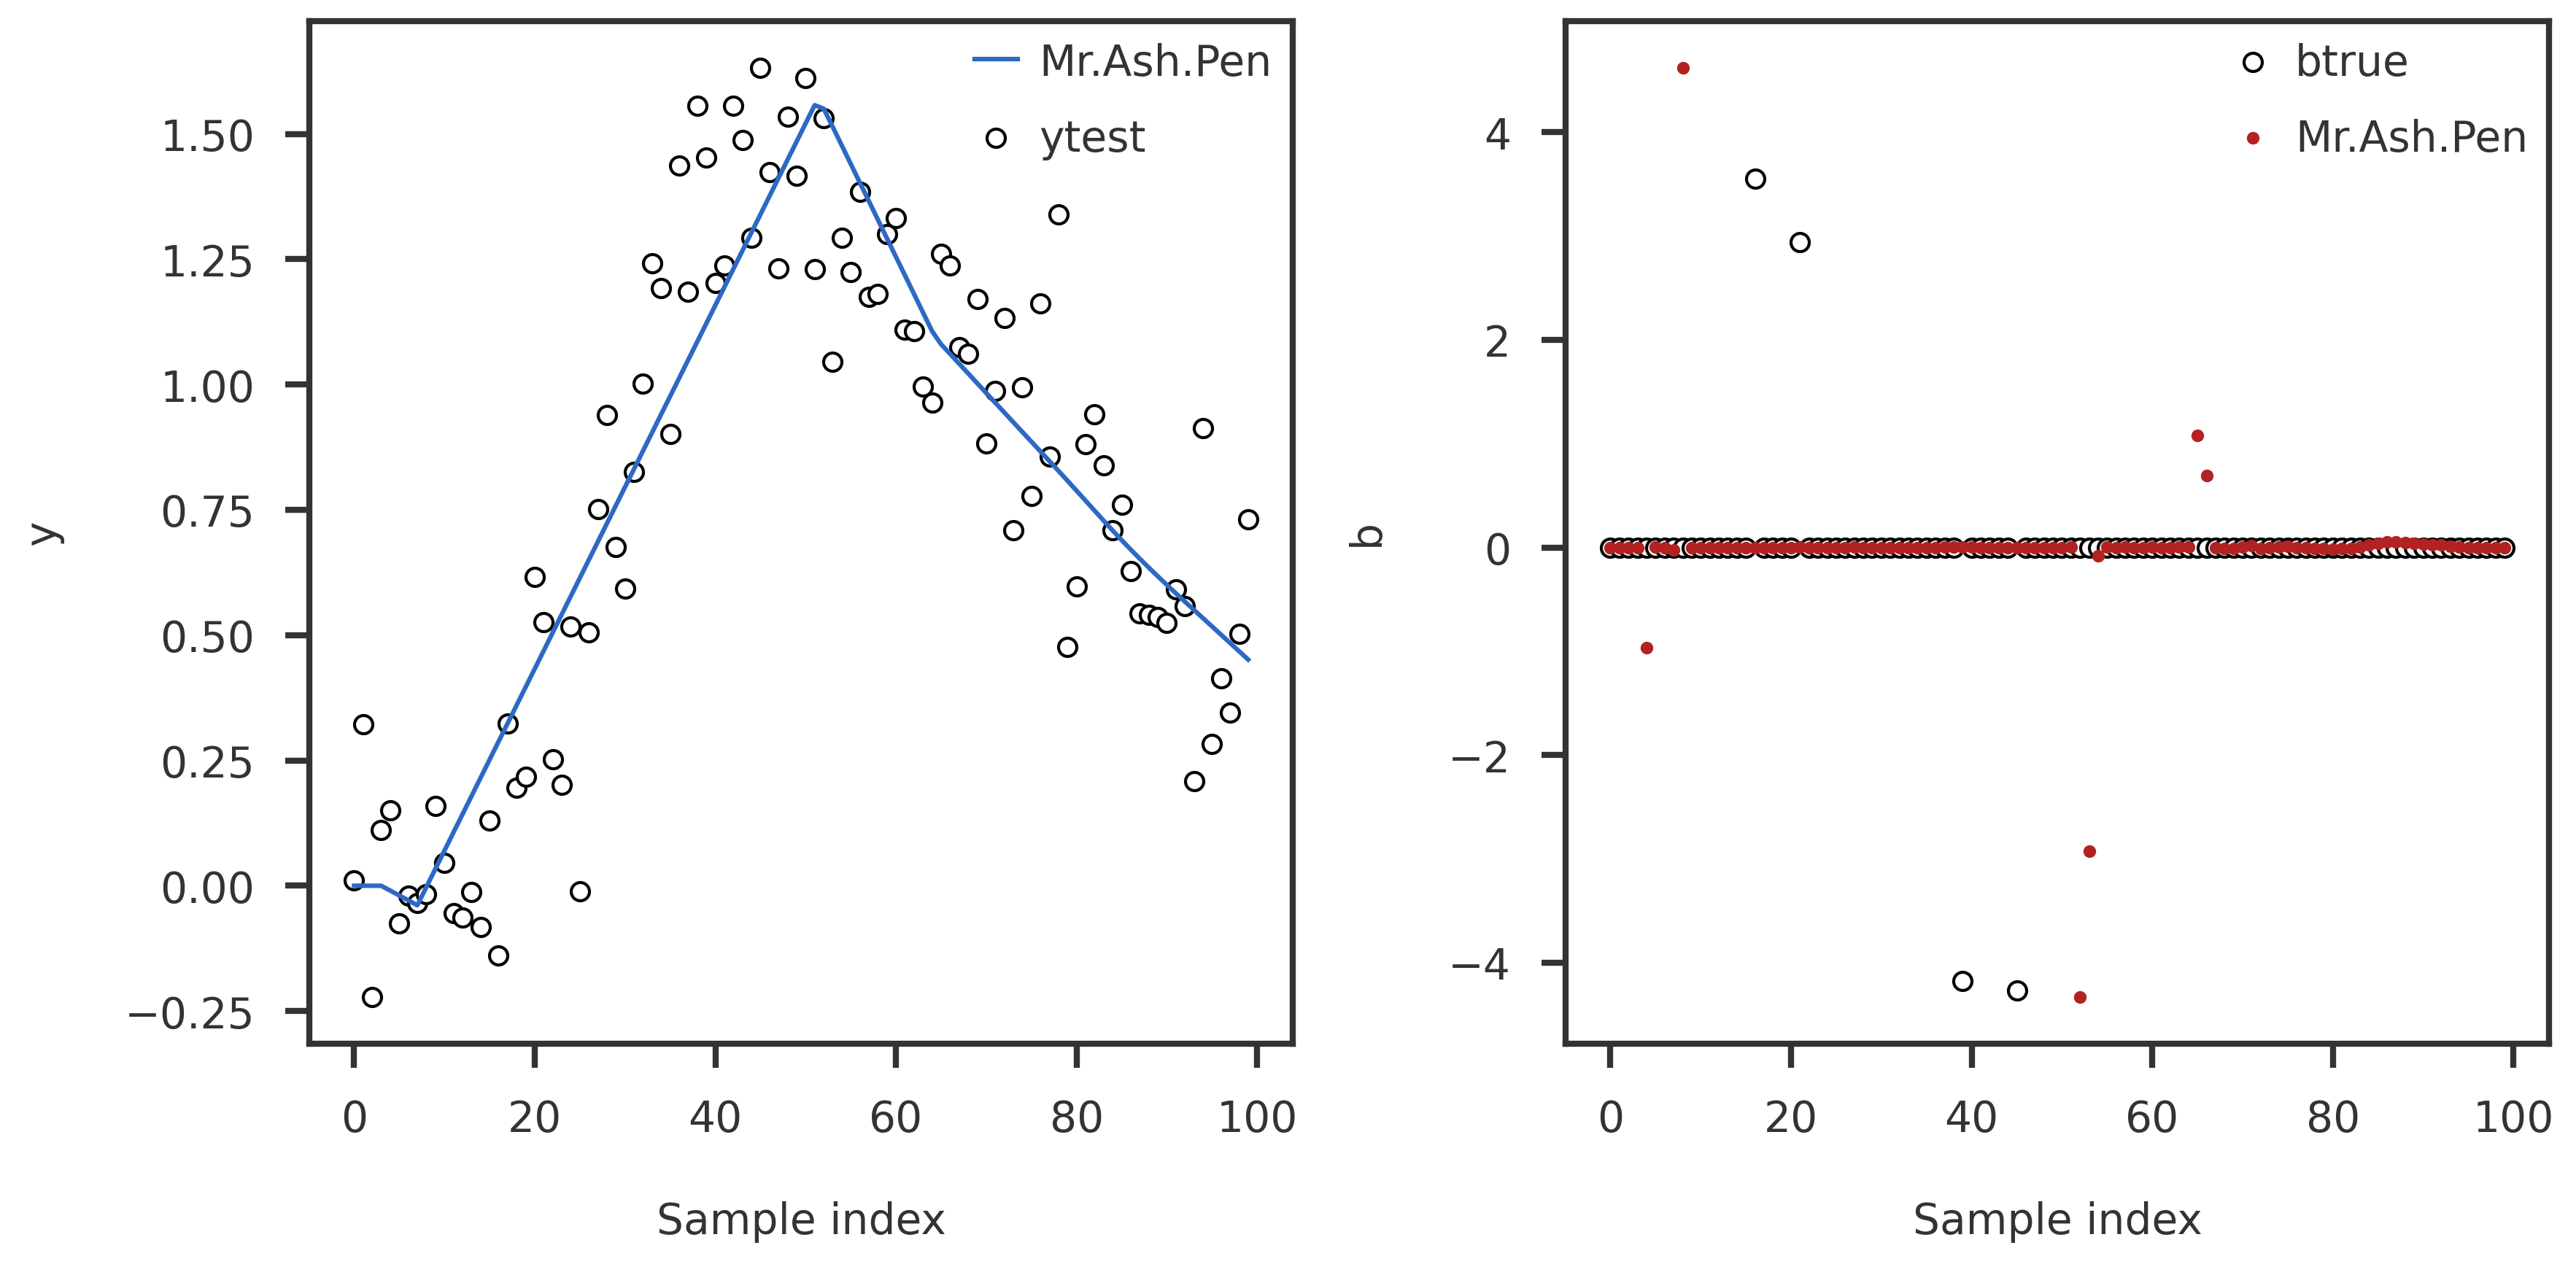

Optimized w:  [0.60782398 0.22012886 0.1074447  0.06169474 0.00290772]


In [12]:
#collapse-hide

n = 100
p = 100
p_causal = 4
snr = 20
k = 5

X, y, Xtest, ytest, beta, se = simulate.changepoint_predictors (n, p, p_causal, snr, 
                                                                k = 1, signal = 'gamma', seed = 10)

residual_var = se * se

## Prior
w = np.zeros(k)
w[0] = 0
w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
w[k-1] = 1 - np.sum(w)
prior_grid = np.arange(k) * 1

print("Initial w: ", w)
print("Prior_grid: ", prior_grid)
print()

b0 = np.zeros(p)
plr_lbfgs = MrASHPen(optimize_w = True, debug = False)
plr_lbfgs.fit(X, y, prior_grid, binit = b0, winit = w, s2init = residual_var)

plot_trendfilter_mrashpen(X, y, beta, ytest, plr_lbfgs)

print("Optimized w: ", plr_lbfgs.prior)